In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_0_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(716456, 828)
(716456, 1)
validation
(107504, 828)
(107504, 1)
test
(80848, 828)
(80848, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/72 [..............................] - ETA: 1:32 - loss: 0.2249 - STD: 1.7611e-04 - MAE: 0.4638

 4/72 [>.............................] - ETA: 2s - loss: 0.0787 - STD: 3.7761e-04 - MAE: 0.2196  

 5/72 [=>............................] - ETA: 2s - loss: 0.0664 - STD: 3.3865e-04 - MAE: 0.1951

 6/72 [=>............................] - ETA: 3s - loss: 0.0592 - STD: 2.9959e-04 - MAE: 0.1825

 7/72 [=>............................] - ETA: 3s - loss: 0.0545 - STD: 2.6605e-04 - MAE: 0.1753

 8/72 [==>...........................] - ETA: 3s - loss: 0.0513 - STD: 2.3774e-04 - MAE: 0.1708

 9/72 [==>...........................] - ETA: 3s - loss: 0.0490 - STD: 2.1419e-04 - MAE: 0.1680

10/72 [===>..........................] - ETA: 3s - loss: 0.0472 - STD: 1.9433e-04 - MAE: 0.1659

11/72 [===>..........................] - ETA: 3s - loss: 0.0457 - STD: 1.7742e-04 - MAE: 0.1642

12/72 [====>.........................] - ETA: 3s - loss: 0.0445 - STD: 1.6314e-04 - MAE: 0.1628

13/72 [====>.........................] - ETA: 3s - loss: 0.0435 - STD: 1.5113e-04 - MAE: 0.1616

14/72 [====>.........................] - ETA: 3s - loss: 0.0425 - STD: 1.4110e-04 - MAE: 0.1603

15/72 [=====>........................] - ETA: 3s - loss: 0.0416 - STD: 1.3261e-04 - MAE: 0.1589

16/72 [=====>........................] - ETA: 3s - loss: 0.0407 - STD: 1.2547e-04 - MAE: 0.1575

17/72 [======>.......................] - ETA: 3s - loss: 0.0399 - STD: 1.1940e-04 - MAE: 0.1559

18/72 [======>.......................] - ETA: 3s - loss: 0.0390 - STD: 1.1425e-04 - MAE: 0.1541

19/72 [======>.......................] - ETA: 3s - loss: 0.0382 - STD: 1.0977e-04 - MAE: 0.1522

20/72 [=======>......................] - ETA: 3s - loss: 0.0373 - STD: 1.0591e-04 - MAE: 0.1501

21/72 [=======>......................] - ETA: 3s - loss: 0.0364 - STD: 1.0272e-04 - MAE: 0.1478

22/72 [========>.....................] - ETA: 3s - loss: 0.0354 - STD: 9.9877e-05 - MAE: 0.1452

23/72 [========>.....................] - ETA: 3s - loss: 0.0345 - STD: 9.7349e-05 - MAE: 0.1425

24/72 [=========>....................] - ETA: 3s - loss: 0.0335 - STD: 9.5044e-05 - MAE: 0.1398

25/72 [=========>....................] - ETA: 3s - loss: 0.0326 - STD: 9.2960e-05 - MAE: 0.1373

26/72 [=========>....................] - ETA: 4s - loss: 0.0320 - STD: 9.1058e-05 - MAE: 0.1349

30/72 [===========>..................] - ETA: 3s - loss: 0.0291 - STD: 8.4033e-05 - MAE: 0.1284

31/72 [===========>..................] - ETA: 3s - loss: 0.0286 - STD: 8.2357e-05 - MAE: 0.1274

32/72 [============>.................] - ETA: 3s - loss: 0.0281 - STD: 8.0782e-05 - MAE: 0.1264

33/72 [============>.................] - ETA: 3s - loss: 0.0276 - STD: 7.9088e-05 - MAE: 0.1255

34/72 [=============>................] - ETA: 3s - loss: 0.0272 - STD: 7.7501e-05 - MAE: 0.1245

35/72 [=============>................] - ETA: 2s - loss: 0.0267 - STD: 7.5906e-05 - MAE: 0.1235

36/72 [==============>...............] - ETA: 2s - loss: 0.0262 - STD: 7.4372e-05 - MAE: 0.1224

37/72 [==============>...............] - ETA: 2s - loss: 0.0258 - STD: 7.2856e-05 - MAE: 0.1213

38/72 [==============>...............] - ETA: 2s - loss: 0.0254 - STD: 7.1414e-05 - MAE: 0.1202

39/72 [===============>..............] - ETA: 2s - loss: 0.0250 - STD: 6.9953e-05 - MAE: 0.1191

40/72 [===============>..............] - ETA: 2s - loss: 0.0246 - STD: 6.8559e-05 - MAE: 0.1180

41/72 [================>.............] - ETA: 2s - loss: 0.0242 - STD: 6.7204e-05 - MAE: 0.1170

42/72 [================>.............] - ETA: 2s - loss: 0.0239 - STD: 6.5930e-05 - MAE: 0.1160

43/72 [================>.............] - ETA: 2s - loss: 0.0236 - STD: 6.4672e-05 - MAE: 0.1150

44/72 [=================>............] - ETA: 2s - loss: 0.0233 - STD: 6.3503e-05 - MAE: 0.1141

45/72 [=================>............] - ETA: 2s - loss: 0.0230 - STD: 6.2352e-05 - MAE: 0.1133

46/72 [==================>...........] - ETA: 2s - loss: 0.0227 - STD: 6.1265e-05 - MAE: 0.1124

47/72 [==================>...........] - ETA: 1s - loss: 0.0224 - STD: 6.0212e-05 - MAE: 0.1116

48/72 [===================>..........] - ETA: 1s - loss: 0.0222 - STD: 5.9187e-05 - MAE: 0.1109

49/72 [===================>..........] - ETA: 1s - loss: 0.0219 - STD: 5.8239e-05 - MAE: 0.1102

50/72 [===================>..........] - ETA: 1s - loss: 0.0217 - STD: 5.7308e-05 - MAE: 0.1095

51/72 [====================>.........] - ETA: 1s - loss: 0.0214 - STD: 5.6416e-05 - MAE: 0.1088

52/72 [====================>.........] - ETA: 1s - loss: 0.0212 - STD: 5.5579e-05 - MAE: 0.1082

53/72 [=====================>........] - ETA: 1s - loss: 0.0210 - STD: 5.4799e-05 - MAE: 0.1076

54/72 [=====================>........] - ETA: 1s - loss: 0.0208 - STD: 5.3973e-05 - MAE: 0.1071

55/72 [=====================>........] - ETA: 1s - loss: 0.0206 - STD: 5.3172e-05 - MAE: 0.1066

56/72 [======================>.......] - ETA: 1s - loss: 0.0204 - STD: 5.2420e-05 - MAE: 0.1061

57/72 [======================>.......] - ETA: 1s - loss: 0.0202 - STD: 5.1702e-05 - MAE: 0.1056

58/72 [=======================>......] - ETA: 1s - loss: 0.0200 - STD: 5.1012e-05 - MAE: 0.1052

59/72 [=======================>......] - ETA: 0s - loss: 0.0198 - STD: 5.0338e-05 - MAE: 0.1047

60/72 [========================>.....] - ETA: 0s - loss: 0.0197 - STD: 4.9679e-05 - MAE: 0.1043

61/72 [========================>.....] - ETA: 0s - loss: 0.0195 - STD: 4.9030e-05 - MAE: 0.1039

62/72 [========================>.....] - ETA: 0s - loss: 0.0193 - STD: 4.8435e-05 - MAE: 0.1035

63/72 [=========================>....] - ETA: 0s - loss: 0.0192 - STD: 4.7855e-05 - MAE: 0.1031

64/72 [=========================>....] - ETA: 0s - loss: 0.0190 - STD: 4.7311e-05 - MAE: 0.1027

65/72 [==========================>...] - ETA: 0s - loss: 0.0189 - STD: 4.6778e-05 - MAE: 0.1023

66/72 [==========================>...] - ETA: 0s - loss: 0.0188 - STD: 4.6253e-05 - MAE: 0.1019

67/72 [==========================>...] - ETA: 0s - loss: 0.0186 - STD: 4.5770e-05 - MAE: 0.1016

68/72 [===========================>..] - ETA: 0s - loss: 0.0185 - STD: 4.5286e-05 - MAE: 0.1012

69/72 [===========================>..] - ETA: 0s - loss: 0.0184 - STD: 4.4796e-05 - MAE: 0.1008

70/72 [============================>.] - ETA: 0s - loss: 0.0182 - STD: 4.4326e-05 - MAE: 0.1005

71/72 [============================>.] - ETA: 0s - loss: 0.0181 - STD: 4.3877e-05 - MAE: 0.1002

72/72 [==============================] - ETA: 0s - loss: 0.0180 - STD: 4.3437e-05 - MAE: 0.0998

72/72 [==============================] - 7s 85ms/step - loss: 0.0180 - STD: 4.3437e-05 - MAE: 0.0998 - val_loss: 0.0104 - val_STD: 9.6465e-06 - val_MAE: 0.0794


Epoch 2/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0100 - STD: 1.2433e-05 - MAE: 0.0775

 3/72 [>.............................] - ETA: 4s - loss: 0.0098 - STD: 1.2822e-05 - MAE: 0.0769

 4/72 [>.............................] - ETA: 4s - loss: 0.0097 - STD: 1.2938e-05 - MAE: 0.0768

 5/72 [=>............................] - ETA: 4s - loss: 0.0098 - STD: 1.3022e-05 - MAE: 0.0770

 6/72 [=>............................] - ETA: 4s - loss: 0.0097 - STD: 1.3077e-05 - MAE: 0.0770

 7/72 [=>............................] - ETA: 4s - loss: 0.0097 - STD: 1.3182e-05 - MAE: 0.0771

 8/72 [==>...........................] - ETA: 4s - loss: 0.0097 - STD: 1.3299e-05 - MAE: 0.0772

 9/72 [==>...........................] - ETA: 4s - loss: 0.0097 - STD: 1.3379e-05 - MAE: 0.0772

10/72 [===>..........................] - ETA: 4s - loss: 0.0097 - STD: 1.3451e-05 - MAE: 0.0773

11/72 [===>..........................] - ETA: 4s - loss: 0.0097 - STD: 1.3507e-05 - MAE: 0.0773

12/72 [====>.........................] - ETA: 4s - loss: 0.0096 - STD: 1.3583e-05 - MAE: 0.0773

13/72 [====>.........................] - ETA: 4s - loss: 0.0096 - STD: 1.3676e-05 - MAE: 0.0773

14/72 [====>.........................] - ETA: 4s - loss: 0.0096 - STD: 1.3751e-05 - MAE: 0.0773

15/72 [=====>........................] - ETA: 4s - loss: 0.0096 - STD: 1.3781e-05 - MAE: 0.0773

16/72 [=====>........................] - ETA: 3s - loss: 0.0096 - STD: 1.3856e-05 - MAE: 0.0773

17/72 [======>.......................] - ETA: 3s - loss: 0.0096 - STD: 1.3934e-05 - MAE: 0.0773

18/72 [======>.......................] - ETA: 3s - loss: 0.0096 - STD: 1.4013e-05 - MAE: 0.0772

19/72 [======>.......................] - ETA: 3s - loss: 0.0096 - STD: 1.4122e-05 - MAE: 0.0773

20/72 [=======>......................] - ETA: 3s - loss: 0.0096 - STD: 1.4229e-05 - MAE: 0.0773

21/72 [=======>......................] - ETA: 3s - loss: 0.0096 - STD: 1.4331e-05 - MAE: 0.0772

22/72 [========>.....................] - ETA: 3s - loss: 0.0096 - STD: 1.4442e-05 - MAE: 0.0771

23/72 [========>.....................] - ETA: 3s - loss: 0.0096 - STD: 1.4543e-05 - MAE: 0.0771

24/72 [=========>....................] - ETA: 3s - loss: 0.0096 - STD: 1.4642e-05 - MAE: 0.0770

25/72 [=========>....................] - ETA: 3s - loss: 0.0096 - STD: 1.4757e-05 - MAE: 0.0770

26/72 [=========>....................] - ETA: 3s - loss: 0.0096 - STD: 1.4865e-05 - MAE: 0.0771

27/72 [==========>...................] - ETA: 3s - loss: 0.0096 - STD: 1.4962e-05 - MAE: 0.0770

28/72 [==========>...................] - ETA: 3s - loss: 0.0096 - STD: 1.5046e-05 - MAE: 0.0770

29/72 [===========>..................] - ETA: 3s - loss: 0.0096 - STD: 1.5136e-05 - MAE: 0.0770

30/72 [===========>..................] - ETA: 2s - loss: 0.0096 - STD: 1.5218e-05 - MAE: 0.0770

31/72 [===========>..................] - ETA: 2s - loss: 0.0096 - STD: 1.5303e-05 - MAE: 0.0770

32/72 [============>.................] - ETA: 2s - loss: 0.0096 - STD: 1.5392e-05 - MAE: 0.0770

33/72 [============>.................] - ETA: 2s - loss: 0.0096 - STD: 1.5488e-05 - MAE: 0.0771

34/72 [=============>................] - ETA: 2s - loss: 0.0096 - STD: 1.5591e-05 - MAE: 0.0771

35/72 [=============>................] - ETA: 2s - loss: 0.0096 - STD: 1.5689e-05 - MAE: 0.0771

36/72 [==============>...............] - ETA: 2s - loss: 0.0096 - STD: 1.5790e-05 - MAE: 0.0771

37/72 [==============>...............] - ETA: 2s - loss: 0.0096 - STD: 1.5889e-05 - MAE: 0.0771

38/72 [==============>...............] - ETA: 2s - loss: 0.0096 - STD: 1.5995e-05 - MAE: 0.0771

39/72 [===============>..............] - ETA: 2s - loss: 0.0096 - STD: 1.6103e-05 - MAE: 0.0771

40/72 [===============>..............] - ETA: 2s - loss: 0.0096 - STD: 1.6213e-05 - MAE: 0.0771

41/72 [================>.............] - ETA: 2s - loss: 0.0096 - STD: 1.6326e-05 - MAE: 0.0771

42/72 [================>.............] - ETA: 2s - loss: 0.0096 - STD: 1.6448e-05 - MAE: 0.0771

43/72 [================>.............] - ETA: 2s - loss: 0.0096 - STD: 1.6569e-05 - MAE: 0.0771

44/72 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 1.6684e-05 - MAE: 0.0771

45/72 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 1.6804e-05 - MAE: 0.0771

46/72 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 1.6937e-05 - MAE: 0.0771

47/72 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 1.7078e-05 - MAE: 0.0771

48/72 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 1.7213e-05 - MAE: 0.0771

49/72 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 1.7350e-05 - MAE: 0.0771

50/72 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 1.7497e-05 - MAE: 0.0771

51/72 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 1.7649e-05 - MAE: 0.0771

52/72 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 1.7806e-05 - MAE: 0.0771

53/72 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 1.7967e-05 - MAE: 0.0771

54/72 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 1.8120e-05 - MAE: 0.0771

55/72 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 1.8286e-05 - MAE: 0.0771

56/72 [======================>.......] - ETA: 1s - loss: 0.0096 - STD: 1.8463e-05 - MAE: 0.0771

57/72 [======================>.......] - ETA: 1s - loss: 0.0096 - STD: 1.8641e-05 - MAE: 0.0771

58/72 [=======================>......] - ETA: 0s - loss: 0.0096 - STD: 1.8824e-05 - MAE: 0.0771

59/72 [=======================>......] - ETA: 0s - loss: 0.0096 - STD: 1.9008e-05 - MAE: 0.0771

60/72 [========================>.....] - ETA: 0s - loss: 0.0096 - STD: 1.9195e-05 - MAE: 0.0771

61/72 [========================>.....] - ETA: 0s - loss: 0.0096 - STD: 1.9395e-05 - MAE: 0.0771

62/72 [========================>.....] - ETA: 0s - loss: 0.0096 - STD: 1.9597e-05 - MAE: 0.0771

63/72 [=========================>....] - ETA: 0s - loss: 0.0096 - STD: 1.9804e-05 - MAE: 0.0771

64/72 [=========================>....] - ETA: 0s - loss: 0.0096 - STD: 2.0022e-05 - MAE: 0.0771

65/72 [==========================>...] - ETA: 0s - loss: 0.0096 - STD: 2.0252e-05 - MAE: 0.0771

66/72 [==========================>...] - ETA: 0s - loss: 0.0096 - STD: 2.0490e-05 - MAE: 0.0771

67/72 [==========================>...] - ETA: 0s - loss: 0.0096 - STD: 2.0725e-05 - MAE: 0.0771

68/72 [===========================>..] - ETA: 0s - loss: 0.0096 - STD: 2.0960e-05 - MAE: 0.0771

69/72 [===========================>..] - ETA: 0s - loss: 0.0096 - STD: 2.1209e-05 - MAE: 0.0771

70/72 [============================>.] - ETA: 0s - loss: 0.0096 - STD: 2.1454e-05 - MAE: 0.0771

71/72 [============================>.] - ETA: 0s - loss: 0.0096 - STD: 2.1698e-05 - MAE: 0.0771

72/72 [==============================] - ETA: 0s - loss: 0.0096 - STD: 2.1947e-05 - MAE: 0.0771

72/72 [==============================] - 5s 74ms/step - loss: 0.0096 - STD: 2.1947e-05 - MAE: 0.0771 - val_loss: 0.0103 - val_STD: 3.7469e-05 - val_MAE: 0.0799


Epoch 3/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0096 - STD: 4.0415e-05 - MAE: 0.0775

 2/72 [..............................] - ETA: 5s - loss: 0.0096 - STD: 4.0567e-05 - MAE: 0.0774

 3/72 [>.............................] - ETA: 5s - loss: 0.0096 - STD: 4.0638e-05 - MAE: 0.0772

 4/72 [>.............................] - ETA: 4s - loss: 0.0096 - STD: 4.0851e-05 - MAE: 0.0772

 5/72 [=>............................] - ETA: 4s - loss: 0.0097 - STD: 4.1238e-05 - MAE: 0.0772

 6/72 [=>............................] - ETA: 4s - loss: 0.0097 - STD: 4.1669e-05 - MAE: 0.0773

 7/72 [=>............................] - ETA: 4s - loss: 0.0097 - STD: 4.2070e-05 - MAE: 0.0772

 8/72 [==>...........................] - ETA: 4s - loss: 0.0097 - STD: 4.2484e-05 - MAE: 0.0772

 9/72 [==>...........................] - ETA: 4s - loss: 0.0096 - STD: 4.2885e-05 - MAE: 0.0771

10/72 [===>..........................] - ETA: 4s - loss: 0.0096 - STD: 4.3317e-05 - MAE: 0.0771

11/72 [===>..........................] - ETA: 4s - loss: 0.0096 - STD: 4.3726e-05 - MAE: 0.0770

12/72 [====>.........................] - ETA: 4s - loss: 0.0096 - STD: 4.4159e-05 - MAE: 0.0771

13/72 [====>.........................] - ETA: 4s - loss: 0.0096 - STD: 4.4611e-05 - MAE: 0.0771

14/72 [====>.........................] - ETA: 4s - loss: 0.0096 - STD: 4.5071e-05 - MAE: 0.0772

15/72 [=====>........................] - ETA: 4s - loss: 0.0096 - STD: 4.5592e-05 - MAE: 0.0772

16/72 [=====>........................] - ETA: 4s - loss: 0.0097 - STD: 4.6079e-05 - MAE: 0.0773

17/72 [======>.......................] - ETA: 3s - loss: 0.0097 - STD: 4.6564e-05 - MAE: 0.0772

18/72 [======>.......................] - ETA: 3s - loss: 0.0096 - STD: 4.7051e-05 - MAE: 0.0772

19/72 [======>.......................] - ETA: 3s - loss: 0.0096 - STD: 4.7567e-05 - MAE: 0.0772

20/72 [=======>......................] - ETA: 3s - loss: 0.0096 - STD: 4.8089e-05 - MAE: 0.0772

21/72 [=======>......................] - ETA: 3s - loss: 0.0096 - STD: 4.8601e-05 - MAE: 0.0772

22/72 [========>.....................] - ETA: 3s - loss: 0.0096 - STD: 4.9101e-05 - MAE: 0.0772

23/72 [========>.....................] - ETA: 3s - loss: 0.0096 - STD: 4.9633e-05 - MAE: 0.0772

24/72 [=========>....................] - ETA: 3s - loss: 0.0096 - STD: 5.0210e-05 - MAE: 0.0772

25/72 [=========>....................] - ETA: 3s - loss: 0.0096 - STD: 5.0792e-05 - MAE: 0.0772

26/72 [=========>....................] - ETA: 3s - loss: 0.0096 - STD: 5.1395e-05 - MAE: 0.0772

27/72 [==========>...................] - ETA: 3s - loss: 0.0096 - STD: 5.2010e-05 - MAE: 0.0771

28/72 [==========>...................] - ETA: 3s - loss: 0.0096 - STD: 5.2616e-05 - MAE: 0.0772

29/72 [===========>..................] - ETA: 3s - loss: 0.0096 - STD: 5.3229e-05 - MAE: 0.0772

30/72 [===========>..................] - ETA: 3s - loss: 0.0096 - STD: 5.3869e-05 - MAE: 0.0772

32/72 [============>.................] - ETA: 2s - loss: 0.0096 - STD: 5.5112e-05 - MAE: 0.0772

33/72 [============>.................] - ETA: 2s - loss: 0.0096 - STD: 5.5810e-05 - MAE: 0.0772

34/72 [=============>................] - ETA: 2s - loss: 0.0096 - STD: 5.6488e-05 - MAE: 0.0772

35/72 [=============>................] - ETA: 2s - loss: 0.0096 - STD: 5.7172e-05 - MAE: 0.0771

36/72 [==============>...............] - ETA: 2s - loss: 0.0096 - STD: 5.7873e-05 - MAE: 0.0771

37/72 [==============>...............] - ETA: 2s - loss: 0.0096 - STD: 5.8587e-05 - MAE: 0.0771

38/72 [==============>...............] - ETA: 2s - loss: 0.0096 - STD: 5.9294e-05 - MAE: 0.0771

39/72 [===============>..............] - ETA: 2s - loss: 0.0096 - STD: 6.0050e-05 - MAE: 0.0771

40/72 [===============>..............] - ETA: 2s - loss: 0.0096 - STD: 6.0806e-05 - MAE: 0.0771

41/72 [================>.............] - ETA: 2s - loss: 0.0096 - STD: 6.1555e-05 - MAE: 0.0771

42/72 [================>.............] - ETA: 2s - loss: 0.0096 - STD: 6.2325e-05 - MAE: 0.0772

43/72 [================>.............] - ETA: 2s - loss: 0.0096 - STD: 6.3102e-05 - MAE: 0.0772

44/72 [=================>............] - ETA: 2s - loss: 0.0096 - STD: 6.3905e-05 - MAE: 0.0772

45/72 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 6.4749e-05 - MAE: 0.0771

46/72 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 6.5577e-05 - MAE: 0.0771

47/72 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 6.6429e-05 - MAE: 0.0771

48/72 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 6.7292e-05 - MAE: 0.0771

49/72 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 6.8167e-05 - MAE: 0.0771

50/72 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 6.9068e-05 - MAE: 0.0771

51/72 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 6.9980e-05 - MAE: 0.0771

52/72 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 7.0893e-05 - MAE: 0.0771

53/72 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 7.1855e-05 - MAE: 0.0771

54/72 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 7.2815e-05 - MAE: 0.0771

55/72 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 7.3792e-05 - MAE: 0.0771

56/72 [======================>.......] - ETA: 1s - loss: 0.0096 - STD: 7.4775e-05 - MAE: 0.0771

57/72 [======================>.......] - ETA: 1s - loss: 0.0096 - STD: 7.5788e-05 - MAE: 0.0771

58/72 [=======================>......] - ETA: 0s - loss: 0.0096 - STD: 7.6828e-05 - MAE: 0.0770

59/72 [=======================>......] - ETA: 0s - loss: 0.0096 - STD: 7.7860e-05 - MAE: 0.0770

60/72 [========================>.....] - ETA: 0s - loss: 0.0096 - STD: 7.8895e-05 - MAE: 0.0771

61/72 [========================>.....] - ETA: 0s - loss: 0.0096 - STD: 7.9970e-05 - MAE: 0.0770

62/72 [========================>.....] - ETA: 0s - loss: 0.0096 - STD: 8.1065e-05 - MAE: 0.0770

63/72 [=========================>....] - ETA: 0s - loss: 0.0096 - STD: 8.2189e-05 - MAE: 0.0771

64/72 [=========================>....] - ETA: 0s - loss: 0.0096 - STD: 8.3331e-05 - MAE: 0.0771

65/72 [==========================>...] - ETA: 0s - loss: 0.0096 - STD: 8.4491e-05 - MAE: 0.0770

66/72 [==========================>...] - ETA: 0s - loss: 0.0096 - STD: 8.5710e-05 - MAE: 0.0770

67/72 [==========================>...] - ETA: 0s - loss: 0.0096 - STD: 8.6922e-05 - MAE: 0.0770

68/72 [===========================>..] - ETA: 0s - loss: 0.0096 - STD: 8.8164e-05 - MAE: 0.0770

69/72 [===========================>..] - ETA: 0s - loss: 0.0096 - STD: 8.9428e-05 - MAE: 0.0770

70/72 [============================>.] - ETA: 0s - loss: 0.0096 - STD: 9.0771e-05 - MAE: 0.0770

71/72 [============================>.] - ETA: 0s - loss: 0.0096 - STD: 9.2103e-05 - MAE: 0.0770

72/72 [==============================] - ETA: 0s - loss: 0.0096 - STD: 9.3503e-05 - MAE: 0.0770

72/72 [==============================] - 5s 75ms/step - loss: 0.0096 - STD: 9.3503e-05 - MAE: 0.0770 - val_loss: 0.0103 - val_STD: 1.8811e-04 - val_MAE: 0.0799


Epoch 4/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0095 - STD: 1.9819e-04 - MAE: 0.0767

 2/72 [..............................] - ETA: 5s - loss: 0.0095 - STD: 2.0206e-04 - MAE: 0.0768

 3/72 [>.............................] - ETA: 5s - loss: 0.0096 - STD: 2.0449e-04 - MAE: 0.0770

 4/72 [>.............................] - ETA: 5s - loss: 0.0096 - STD: 2.0680e-04 - MAE: 0.0770

 5/72 [=>............................] - ETA: 5s - loss: 0.0096 - STD: 2.0989e-04 - MAE: 0.0768

 6/72 [=>............................] - ETA: 5s - loss: 0.0096 - STD: 2.1285e-04 - MAE: 0.0770

 7/72 [=>............................] - ETA: 4s - loss: 0.0096 - STD: 2.1624e-04 - MAE: 0.0771

 8/72 [==>...........................] - ETA: 4s - loss: 0.0096 - STD: 2.1941e-04 - MAE: 0.0770

 9/72 [==>...........................] - ETA: 4s - loss: 0.0096 - STD: 2.2293e-04 - MAE: 0.0770

10/72 [===>..........................] - ETA: 4s - loss: 0.0096 - STD: 2.2676e-04 - MAE: 0.0770

11/72 [===>..........................] - ETA: 4s - loss: 0.0096 - STD: 2.2989e-04 - MAE: 0.0770

12/72 [====>.........................] - ETA: 4s - loss: 0.0096 - STD: 2.3346e-04 - MAE: 0.0770

13/72 [====>.........................] - ETA: 4s - loss: 0.0096 - STD: 2.3694e-04 - MAE: 0.0770

14/72 [====>.........................] - ETA: 4s - loss: 0.0096 - STD: 2.4068e-04 - MAE: 0.0771

15/72 [=====>........................] - ETA: 4s - loss: 0.0096 - STD: 2.4448e-04 - MAE: 0.0771

16/72 [=====>........................] - ETA: 4s - loss: 0.0096 - STD: 2.4833e-04 - MAE: 0.0770

17/72 [======>.......................] - ETA: 4s - loss: 0.0096 - STD: 2.5241e-04 - MAE: 0.0770

18/72 [======>.......................] - ETA: 3s - loss: 0.0096 - STD: 2.5647e-04 - MAE: 0.0770

19/72 [======>.......................] - ETA: 3s - loss: 0.0096 - STD: 2.6079e-04 - MAE: 0.0770

20/72 [=======>......................] - ETA: 3s - loss: 0.0096 - STD: 2.6527e-04 - MAE: 0.0770

21/72 [=======>......................] - ETA: 3s - loss: 0.0096 - STD: 2.7003e-04 - MAE: 0.0770

22/72 [========>.....................] - ETA: 3s - loss: 0.0096 - STD: 2.7465e-04 - MAE: 0.0770

23/72 [========>.....................] - ETA: 3s - loss: 0.0096 - STD: 2.7940e-04 - MAE: 0.0769

24/72 [=========>....................] - ETA: 3s - loss: 0.0096 - STD: 2.8440e-04 - MAE: 0.0769

25/72 [=========>....................] - ETA: 3s - loss: 0.0096 - STD: 2.8923e-04 - MAE: 0.0769

26/72 [=========>....................] - ETA: 3s - loss: 0.0096 - STD: 2.9437e-04 - MAE: 0.0769

27/72 [==========>...................] - ETA: 3s - loss: 0.0096 - STD: 2.9965e-04 - MAE: 0.0769

28/72 [==========>...................] - ETA: 3s - loss: 0.0096 - STD: 3.0513e-04 - MAE: 0.0769

29/72 [===========>..................] - ETA: 3s - loss: 0.0096 - STD: 3.1093e-04 - MAE: 0.0769

30/72 [===========>..................] - ETA: 3s - loss: 0.0096 - STD: 3.1675e-04 - MAE: 0.0770

32/72 [============>.................] - ETA: 2s - loss: 0.0096 - STD: 3.2898e-04 - MAE: 0.0770

33/72 [============>.................] - ETA: 2s - loss: 0.0096 - STD: 3.3519e-04 - MAE: 0.0770

34/72 [=============>................] - ETA: 2s - loss: 0.0096 - STD: 3.4164e-04 - MAE: 0.0770

35/72 [=============>................] - ETA: 2s - loss: 0.0096 - STD: 3.4837e-04 - MAE: 0.0770

36/72 [==============>...............] - ETA: 2s - loss: 0.0096 - STD: 3.5525e-04 - MAE: 0.0770

37/72 [==============>...............] - ETA: 2s - loss: 0.0096 - STD: 3.6236e-04 - MAE: 0.0770

38/72 [==============>...............] - ETA: 2s - loss: 0.0096 - STD: 3.6976e-04 - MAE: 0.0770

39/72 [===============>..............] - ETA: 2s - loss: 0.0096 - STD: 3.7708e-04 - MAE: 0.0770

40/72 [===============>..............] - ETA: 2s - loss: 0.0096 - STD: 3.8498e-04 - MAE: 0.0770

41/72 [================>.............] - ETA: 2s - loss: 0.0096 - STD: 3.9302e-04 - MAE: 0.0770

42/72 [================>.............] - ETA: 2s - loss: 0.0096 - STD: 4.0124e-04 - MAE: 0.0770

43/72 [================>.............] - ETA: 2s - loss: 0.0096 - STD: 4.0961e-04 - MAE: 0.0770

44/72 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 4.1818e-04 - MAE: 0.0770

45/72 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 4.2715e-04 - MAE: 0.0769

46/72 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 4.3660e-04 - MAE: 0.0769

47/72 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 4.4601e-04 - MAE: 0.0769

48/72 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 4.5575e-04 - MAE: 0.0769

49/72 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 4.6590e-04 - MAE: 0.0769

50/72 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 4.7661e-04 - MAE: 0.0769

51/72 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 4.8764e-04 - MAE: 0.0769

52/72 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 4.9928e-04 - MAE: 0.0769

53/72 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 5.1101e-04 - MAE: 0.0769

54/72 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 5.2320e-04 - MAE: 0.0769

55/72 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 5.3579e-04 - MAE: 0.0769

56/72 [======================>.......] - ETA: 1s - loss: 0.0096 - STD: 5.4895e-04 - MAE: 0.0769

57/72 [======================>.......] - ETA: 1s - loss: 0.0096 - STD: 5.6267e-04 - MAE: 0.0769

58/72 [=======================>......] - ETA: 1s - loss: 0.0096 - STD: 5.7660e-04 - MAE: 0.0769

59/72 [=======================>......] - ETA: 0s - loss: 0.0096 - STD: 5.9117e-04 - MAE: 0.0769

60/72 [========================>.....] - ETA: 0s - loss: 0.0096 - STD: 6.0632e-04 - MAE: 0.0769

61/72 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 6.2197e-04 - MAE: 0.0769

62/72 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 6.3826e-04 - MAE: 0.0769

63/72 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 6.5500e-04 - MAE: 0.0769

64/72 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 6.7223e-04 - MAE: 0.0769

65/72 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 6.9004e-04 - MAE: 0.0769

66/72 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 7.0872e-04 - MAE: 0.0769

67/72 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 7.2806e-04 - MAE: 0.0769

68/72 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 7.4818e-04 - MAE: 0.0769

69/72 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 7.6907e-04 - MAE: 0.0768

70/72 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 7.9084e-04 - MAE: 0.0769

71/72 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 8.1338e-04 - MAE: 0.0769

72/72 [==============================] - ETA: 0s - loss: 0.0095 - STD: 8.3703e-04 - MAE: 0.0769

72/72 [==============================] - 5s 75ms/step - loss: 0.0095 - STD: 8.3703e-04 - MAE: 0.0769 - val_loss: 0.0101 - val_STD: 0.0024 - val_MAE: 0.0792


Epoch 5/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0093 - STD: 0.0026 - MAE: 0.0765

 2/72 [..............................] - ETA: 5s - loss: 0.0093 - STD: 0.0027 - MAE: 0.0764

 3/72 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 0.0027 - MAE: 0.0763

 4/72 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 0.0028 - MAE: 0.0763

 5/72 [=>............................] - ETA: 4s - loss: 0.0094 - STD: 0.0028 - MAE: 0.0763

 6/72 [=>............................] - ETA: 4s - loss: 0.0094 - STD: 0.0029 - MAE: 0.0763

 7/72 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 0.0030 - MAE: 0.0762

 8/72 [==>...........................] - ETA: 4s - loss: 0.0093 - STD: 0.0031 - MAE: 0.0761

 9/72 [==>...........................] - ETA: 4s - loss: 0.0093 - STD: 0.0031 - MAE: 0.0763

10/72 [===>..........................] - ETA: 4s - loss: 0.0093 - STD: 0.0032 - MAE: 0.0762

11/72 [===>..........................] - ETA: 4s - loss: 0.0093 - STD: 0.0033 - MAE: 0.0762

12/72 [====>.........................] - ETA: 4s - loss: 0.0093 - STD: 0.0034 - MAE: 0.0762

13/72 [====>.........................] - ETA: 4s - loss: 0.0093 - STD: 0.0035 - MAE: 0.0762

14/72 [====>.........................] - ETA: 4s - loss: 0.0093 - STD: 0.0035 - MAE: 0.0762

15/72 [=====>........................] - ETA: 4s - loss: 0.0093 - STD: 0.0036 - MAE: 0.0761

16/72 [=====>........................] - ETA: 4s - loss: 0.0093 - STD: 0.0037 - MAE: 0.0762

17/72 [======>.......................] - ETA: 3s - loss: 0.0093 - STD: 0.0038 - MAE: 0.0761

18/72 [======>.......................] - ETA: 3s - loss: 0.0093 - STD: 0.0039 - MAE: 0.0761

19/72 [======>.......................] - ETA: 3s - loss: 0.0093 - STD: 0.0040 - MAE: 0.0761

20/72 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 0.0041 - MAE: 0.0760

21/72 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 0.0042 - MAE: 0.0760

22/72 [========>.....................] - ETA: 3s - loss: 0.0093 - STD: 0.0044 - MAE: 0.0760

23/72 [========>.....................] - ETA: 3s - loss: 0.0093 - STD: 0.0045 - MAE: 0.0760

24/72 [=========>....................] - ETA: 3s - loss: 0.0093 - STD: 0.0046 - MAE: 0.0760

25/72 [=========>....................] - ETA: 3s - loss: 0.0093 - STD: 0.0047 - MAE: 0.0759

26/72 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 0.0048 - MAE: 0.0759

27/72 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 0.0050 - MAE: 0.0759

28/72 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 0.0051 - MAE: 0.0759

29/72 [===========>..................] - ETA: 3s - loss: 0.0092 - STD: 0.0053 - MAE: 0.0758

30/72 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 0.0054 - MAE: 0.0758

31/72 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 0.0056 - MAE: 0.0757

32/72 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 0.0057 - MAE: 0.0757

33/72 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 0.0059 - MAE: 0.0757

34/72 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 0.0060 - MAE: 0.0756

35/72 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 0.0062 - MAE: 0.0756

36/72 [==============>...............] - ETA: 2s - loss: 0.0091 - STD: 0.0064 - MAE: 0.0755

37/72 [==============>...............] - ETA: 2s - loss: 0.0091 - STD: 0.0065 - MAE: 0.0754

38/72 [==============>...............] - ETA: 2s - loss: 0.0091 - STD: 0.0067 - MAE: 0.0754

39/72 [===============>..............] - ETA: 2s - loss: 0.0091 - STD: 0.0069 - MAE: 0.0754

40/72 [===============>..............] - ETA: 2s - loss: 0.0091 - STD: 0.0071 - MAE: 0.0753

41/72 [================>.............] - ETA: 2s - loss: 0.0091 - STD: 0.0073 - MAE: 0.0753

42/72 [================>.............] - ETA: 2s - loss: 0.0091 - STD: 0.0075 - MAE: 0.0752

43/72 [================>.............] - ETA: 2s - loss: 0.0091 - STD: 0.0077 - MAE: 0.0751

44/72 [=================>............] - ETA: 2s - loss: 0.0090 - STD: 0.0079 - MAE: 0.0751

45/72 [=================>............] - ETA: 1s - loss: 0.0090 - STD: 0.0082 - MAE: 0.0750

46/72 [==================>...........] - ETA: 1s - loss: 0.0090 - STD: 0.0084 - MAE: 0.0750

47/72 [==================>...........] - ETA: 1s - loss: 0.0090 - STD: 0.0086 - MAE: 0.0749

48/72 [===================>..........] - ETA: 1s - loss: 0.0090 - STD: 0.0088 - MAE: 0.0749

49/72 [===================>..........] - ETA: 1s - loss: 0.0090 - STD: 0.0091 - MAE: 0.0748

50/72 [===================>..........] - ETA: 1s - loss: 0.0090 - STD: 0.0093 - MAE: 0.0748

51/72 [====================>.........] - ETA: 1s - loss: 0.0090 - STD: 0.0096 - MAE: 0.0747

52/72 [====================>.........] - ETA: 1s - loss: 0.0089 - STD: 0.0098 - MAE: 0.0747

53/72 [=====================>........] - ETA: 1s - loss: 0.0089 - STD: 0.0101 - MAE: 0.0746

54/72 [=====================>........] - ETA: 1s - loss: 0.0089 - STD: 0.0103 - MAE: 0.0745

55/72 [=====================>........] - ETA: 1s - loss: 0.0089 - STD: 0.0106 - MAE: 0.0745

56/72 [======================>.......] - ETA: 1s - loss: 0.0089 - STD: 0.0109 - MAE: 0.0744

57/72 [======================>.......] - ETA: 1s - loss: 0.0089 - STD: 0.0111 - MAE: 0.0744

58/72 [=======================>......] - ETA: 1s - loss: 0.0089 - STD: 0.0114 - MAE: 0.0743

59/72 [=======================>......] - ETA: 0s - loss: 0.0088 - STD: 0.0117 - MAE: 0.0743

60/72 [========================>.....] - ETA: 0s - loss: 0.0088 - STD: 0.0119 - MAE: 0.0742

61/72 [========================>.....] - ETA: 0s - loss: 0.0088 - STD: 0.0122 - MAE: 0.0742

63/72 [=========================>....] - ETA: 0s - loss: 0.0088 - STD: 0.0128 - MAE: 0.0741

64/72 [=========================>....] - ETA: 0s - loss: 0.0088 - STD: 0.0130 - MAE: 0.0740

65/72 [==========================>...] - ETA: 0s - loss: 0.0088 - STD: 0.0133 - MAE: 0.0739

66/72 [==========================>...] - ETA: 0s - loss: 0.0088 - STD: 0.0136 - MAE: 0.0739

67/72 [==========================>...] - ETA: 0s - loss: 0.0087 - STD: 0.0139 - MAE: 0.0738

68/72 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.0142 - MAE: 0.0738

69/72 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.0144 - MAE: 0.0737

70/72 [============================>.] - ETA: 0s - loss: 0.0087 - STD: 0.0147 - MAE: 0.0737

71/72 [============================>.] - ETA: 0s - loss: 0.0087 - STD: 0.0150 - MAE: 0.0736

72/72 [==============================] - ETA: 0s - loss: 0.0087 - STD: 0.0152 - MAE: 0.0735

72/72 [==============================] - 5s 75ms/step - loss: 0.0087 - STD: 0.0152 - MAE: 0.0735 - val_loss: 0.0084 - val_STD: 0.0316 - val_MAE: 0.0721


Epoch 6/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0079 - STD: 0.0350 - MAE: 0.0697

 2/72 [..............................] - ETA: 5s - loss: 0.0078 - STD: 0.0351 - MAE: 0.0695

 3/72 [>.............................] - ETA: 5s - loss: 0.0078 - STD: 0.0353 - MAE: 0.0695

 4/72 [>.............................] - ETA: 4s - loss: 0.0078 - STD: 0.0355 - MAE: 0.0695

 5/72 [=>............................] - ETA: 4s - loss: 0.0077 - STD: 0.0356 - MAE: 0.0694

 6/72 [=>............................] - ETA: 4s - loss: 0.0077 - STD: 0.0358 - MAE: 0.0694

 7/72 [=>............................] - ETA: 4s - loss: 0.0077 - STD: 0.0358 - MAE: 0.0693

 8/72 [==>...........................] - ETA: 4s - loss: 0.0078 - STD: 0.0359 - MAE: 0.0694

 9/72 [==>...........................] - ETA: 4s - loss: 0.0078 - STD: 0.0360 - MAE: 0.0694

10/72 [===>..........................] - ETA: 4s - loss: 0.0078 - STD: 0.0360 - MAE: 0.0693

11/72 [===>..........................] - ETA: 4s - loss: 0.0077 - STD: 0.0361 - MAE: 0.0692

12/72 [====>.........................] - ETA: 4s - loss: 0.0077 - STD: 0.0361 - MAE: 0.0692

13/72 [====>.........................] - ETA: 4s - loss: 0.0077 - STD: 0.0361 - MAE: 0.0692

14/72 [====>.........................] - ETA: 4s - loss: 0.0077 - STD: 0.0362 - MAE: 0.0691

15/72 [=====>........................] - ETA: 4s - loss: 0.0077 - STD: 0.0362 - MAE: 0.0691

16/72 [=====>........................] - ETA: 3s - loss: 0.0077 - STD: 0.0362 - MAE: 0.0691

17/72 [======>.......................] - ETA: 3s - loss: 0.0077 - STD: 0.0363 - MAE: 0.0691

18/72 [======>.......................] - ETA: 3s - loss: 0.0077 - STD: 0.0363 - MAE: 0.0691

19/72 [======>.......................] - ETA: 3s - loss: 0.0077 - STD: 0.0364 - MAE: 0.0690

20/72 [=======>......................] - ETA: 3s - loss: 0.0077 - STD: 0.0364 - MAE: 0.0689

21/72 [=======>......................] - ETA: 3s - loss: 0.0077 - STD: 0.0365 - MAE: 0.0688

22/72 [========>.....................] - ETA: 3s - loss: 0.0076 - STD: 0.0366 - MAE: 0.0687

23/72 [========>.....................] - ETA: 3s - loss: 0.0076 - STD: 0.0367 - MAE: 0.0687

24/72 [=========>....................] - ETA: 3s - loss: 0.0076 - STD: 0.0368 - MAE: 0.0687

26/72 [=========>....................] - ETA: 3s - loss: 0.0076 - STD: 0.0368 - MAE: 0.0685

27/72 [==========>...................] - ETA: 3s - loss: 0.0076 - STD: 0.0369 - MAE: 0.0684

28/72 [==========>...................] - ETA: 3s - loss: 0.0076 - STD: 0.0369 - MAE: 0.0683

29/72 [===========>..................] - ETA: 2s - loss: 0.0075 - STD: 0.0370 - MAE: 0.0682

30/72 [===========>..................] - ETA: 2s - loss: 0.0075 - STD: 0.0371 - MAE: 0.0682

31/72 [===========>..................] - ETA: 2s - loss: 0.0075 - STD: 0.0372 - MAE: 0.0681

32/72 [============>.................] - ETA: 2s - loss: 0.0075 - STD: 0.0373 - MAE: 0.0680

33/72 [============>.................] - ETA: 2s - loss: 0.0075 - STD: 0.0374 - MAE: 0.0679

34/72 [=============>................] - ETA: 2s - loss: 0.0075 - STD: 0.0376 - MAE: 0.0678

35/72 [=============>................] - ETA: 2s - loss: 0.0074 - STD: 0.0377 - MAE: 0.0677

36/72 [==============>...............] - ETA: 2s - loss: 0.0074 - STD: 0.0378 - MAE: 0.0676

37/72 [==============>...............] - ETA: 2s - loss: 0.0074 - STD: 0.0379 - MAE: 0.0675

38/72 [==============>...............] - ETA: 2s - loss: 0.0074 - STD: 0.0380 - MAE: 0.0674

39/72 [===============>..............] - ETA: 2s - loss: 0.0074 - STD: 0.0381 - MAE: 0.0673

40/72 [===============>..............] - ETA: 2s - loss: 0.0073 - STD: 0.0382 - MAE: 0.0672

41/72 [================>.............] - ETA: 2s - loss: 0.0073 - STD: 0.0383 - MAE: 0.0670

42/72 [================>.............] - ETA: 2s - loss: 0.0073 - STD: 0.0385 - MAE: 0.0670

43/72 [================>.............] - ETA: 2s - loss: 0.0073 - STD: 0.0386 - MAE: 0.0668

44/72 [=================>............] - ETA: 1s - loss: 0.0072 - STD: 0.0388 - MAE: 0.0667

45/72 [=================>............] - ETA: 1s - loss: 0.0072 - STD: 0.0390 - MAE: 0.0666

46/72 [==================>...........] - ETA: 1s - loss: 0.0072 - STD: 0.0392 - MAE: 0.0664

47/72 [==================>...........] - ETA: 1s - loss: 0.0072 - STD: 0.0394 - MAE: 0.0663

48/72 [===================>..........] - ETA: 1s - loss: 0.0072 - STD: 0.0396 - MAE: 0.0662

49/72 [===================>..........] - ETA: 1s - loss: 0.0071 - STD: 0.0398 - MAE: 0.0661

50/72 [===================>..........] - ETA: 1s - loss: 0.0071 - STD: 0.0401 - MAE: 0.0660

51/72 [====================>.........] - ETA: 1s - loss: 0.0071 - STD: 0.0403 - MAE: 0.0659

52/72 [====================>.........] - ETA: 1s - loss: 0.0071 - STD: 0.0405 - MAE: 0.0658

53/72 [=====================>........] - ETA: 1s - loss: 0.0071 - STD: 0.0407 - MAE: 0.0657

54/72 [=====================>........] - ETA: 1s - loss: 0.0070 - STD: 0.0409 - MAE: 0.0656

55/72 [=====================>........] - ETA: 1s - loss: 0.0070 - STD: 0.0412 - MAE: 0.0655

56/72 [======================>.......] - ETA: 1s - loss: 0.0070 - STD: 0.0413 - MAE: 0.0654

57/72 [======================>.......] - ETA: 1s - loss: 0.0070 - STD: 0.0416 - MAE: 0.0653

58/72 [=======================>......] - ETA: 0s - loss: 0.0070 - STD: 0.0418 - MAE: 0.0652

59/72 [=======================>......] - ETA: 0s - loss: 0.0070 - STD: 0.0420 - MAE: 0.0651

60/72 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0422 - MAE: 0.0650

61/72 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0424 - MAE: 0.0649

62/72 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0426 - MAE: 0.0648

63/72 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0428 - MAE: 0.0647

64/72 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0430 - MAE: 0.0646

65/72 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0432 - MAE: 0.0645

66/72 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0434 - MAE: 0.0644

67/72 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0436 - MAE: 0.0643

68/72 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0438 - MAE: 0.0642

69/72 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0440 - MAE: 0.0641

70/72 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0442 - MAE: 0.0640

71/72 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0444 - MAE: 0.0640

72/72 [==============================] - ETA: 0s - loss: 0.0067 - STD: 0.0446 - MAE: 0.0639

72/72 [==============================] - 5s 74ms/step - loss: 0.0067 - STD: 0.0446 - MAE: 0.0639 - val_loss: 0.0057 - val_STD: 0.0557 - val_MAE: 0.0585


Epoch 7/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0055 - STD: 0.0573 - MAE: 0.0567

 2/72 [..............................] - ETA: 5s - loss: 0.0055 - STD: 0.0571 - MAE: 0.0568

 3/72 [>.............................] - ETA: 5s - loss: 0.0055 - STD: 0.0579 - MAE: 0.0570

 4/72 [>.............................] - ETA: 5s - loss: 0.0055 - STD: 0.0575 - MAE: 0.0569

 5/72 [=>............................] - ETA: 4s - loss: 0.0055 - STD: 0.0573 - MAE: 0.0568

 6/72 [=>............................] - ETA: 4s - loss: 0.0055 - STD: 0.0579 - MAE: 0.0570

 7/72 [=>............................] - ETA: 4s - loss: 0.0055 - STD: 0.0573 - MAE: 0.0569

 8/72 [==>...........................] - ETA: 4s - loss: 0.0055 - STD: 0.0577 - MAE: 0.0572

 9/72 [==>...........................] - ETA: 4s - loss: 0.0055 - STD: 0.0577 - MAE: 0.0571

10/72 [===>..........................] - ETA: 4s - loss: 0.0055 - STD: 0.0577 - MAE: 0.0571

11/72 [===>..........................] - ETA: 4s - loss: 0.0055 - STD: 0.0579 - MAE: 0.0572

12/72 [====>.........................] - ETA: 4s - loss: 0.0056 - STD: 0.0576 - MAE: 0.0572

13/72 [====>.........................] - ETA: 4s - loss: 0.0056 - STD: 0.0580 - MAE: 0.0573

14/72 [====>.........................] - ETA: 4s - loss: 0.0056 - STD: 0.0578 - MAE: 0.0572

15/72 [=====>........................] - ETA: 4s - loss: 0.0056 - STD: 0.0579 - MAE: 0.0571

16/72 [=====>........................] - ETA: 4s - loss: 0.0056 - STD: 0.0581 - MAE: 0.0571

17/72 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0579 - MAE: 0.0570

18/72 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0581 - MAE: 0.0570

19/72 [======>.......................] - ETA: 3s - loss: 0.0055 - STD: 0.0582 - MAE: 0.0570

20/72 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0582 - MAE: 0.0568

21/72 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0583 - MAE: 0.0568

22/72 [========>.....................] - ETA: 3s - loss: 0.0055 - STD: 0.0584 - MAE: 0.0568

23/72 [========>.....................] - ETA: 3s - loss: 0.0055 - STD: 0.0583 - MAE: 0.0568

24/72 [=========>....................] - ETA: 3s - loss: 0.0055 - STD: 0.0585 - MAE: 0.0569

25/72 [=========>....................] - ETA: 3s - loss: 0.0055 - STD: 0.0585 - MAE: 0.0568

26/72 [=========>....................] - ETA: 3s - loss: 0.0055 - STD: 0.0586 - MAE: 0.0568

28/72 [==========>...................] - ETA: 3s - loss: 0.0055 - STD: 0.0587 - MAE: 0.0566

29/72 [===========>..................] - ETA: 3s - loss: 0.0055 - STD: 0.0588 - MAE: 0.0566

30/72 [===========>..................] - ETA: 3s - loss: 0.0055 - STD: 0.0589 - MAE: 0.0566

31/72 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0590 - MAE: 0.0565

32/72 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0591 - MAE: 0.0565

33/72 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0592 - MAE: 0.0565

34/72 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0593 - MAE: 0.0564

35/72 [=============>................] - ETA: 2s - loss: 0.0054 - STD: 0.0594 - MAE: 0.0564

36/72 [==============>...............] - ETA: 2s - loss: 0.0054 - STD: 0.0594 - MAE: 0.0563

37/72 [==============>...............] - ETA: 2s - loss: 0.0054 - STD: 0.0596 - MAE: 0.0563

38/72 [==============>...............] - ETA: 2s - loss: 0.0054 - STD: 0.0596 - MAE: 0.0562

39/72 [===============>..............] - ETA: 2s - loss: 0.0054 - STD: 0.0597 - MAE: 0.0562

40/72 [===============>..............] - ETA: 2s - loss: 0.0054 - STD: 0.0597 - MAE: 0.0561

41/72 [================>.............] - ETA: 2s - loss: 0.0054 - STD: 0.0598 - MAE: 0.0561

42/72 [================>.............] - ETA: 2s - loss: 0.0054 - STD: 0.0597 - MAE: 0.0561

43/72 [================>.............] - ETA: 2s - loss: 0.0054 - STD: 0.0599 - MAE: 0.0561

44/72 [=================>............] - ETA: 2s - loss: 0.0054 - STD: 0.0599 - MAE: 0.0560

45/72 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0599 - MAE: 0.0560

46/72 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0600 - MAE: 0.0560

47/72 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0600 - MAE: 0.0559

48/72 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0601 - MAE: 0.0559

49/72 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0601 - MAE: 0.0558

50/72 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0602 - MAE: 0.0558

51/72 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0603 - MAE: 0.0558

52/72 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0603 - MAE: 0.0557

53/72 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0604 - MAE: 0.0557

54/72 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0604 - MAE: 0.0556

55/72 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0604 - MAE: 0.0556

56/72 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.0605 - MAE: 0.0555

57/72 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.0605 - MAE: 0.0555

58/72 [=======================>......] - ETA: 1s - loss: 0.0053 - STD: 0.0606 - MAE: 0.0555

59/72 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0606 - MAE: 0.0555

60/72 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0607 - MAE: 0.0555

61/72 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0608 - MAE: 0.0554

62/72 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0607 - MAE: 0.0554

63/72 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0608 - MAE: 0.0554

64/72 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0608 - MAE: 0.0554

65/72 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0608 - MAE: 0.0554

66/72 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0610 - MAE: 0.0554

67/72 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0609 - MAE: 0.0554

68/72 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0609 - MAE: 0.0553

69/72 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0610 - MAE: 0.0554

70/72 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0610 - MAE: 0.0553

71/72 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0610 - MAE: 0.0553

72/72 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0611 - MAE: 0.0553

72/72 [==============================] - 6s 77ms/step - loss: 0.0053 - STD: 0.0611 - MAE: 0.0553 - val_loss: 0.0056 - val_STD: 0.0555 - val_MAE: 0.0549


Epoch 8/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0054 - STD: 0.0555 - MAE: 0.0532

 2/72 [..............................] - ETA: 5s - loss: 0.0052 - STD: 0.0585 - MAE: 0.0531

 3/72 [>.............................] - ETA: 5s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0552

 4/72 [>.............................] - ETA: 5s - loss: 0.0053 - STD: 0.0610 - MAE: 0.0545

 5/72 [=>............................] - ETA: 5s - loss: 0.0052 - STD: 0.0604 - MAE: 0.0541

 6/72 [=>............................] - ETA: 4s - loss: 0.0052 - STD: 0.0618 - MAE: 0.0549

 7/72 [=>............................] - ETA: 4s - loss: 0.0052 - STD: 0.0613 - MAE: 0.0545

 8/72 [==>...........................] - ETA: 4s - loss: 0.0052 - STD: 0.0607 - MAE: 0.0542

 9/72 [==>...........................] - ETA: 4s - loss: 0.0052 - STD: 0.0613 - MAE: 0.0545

10/72 [===>..........................] - ETA: 4s - loss: 0.0052 - STD: 0.0616 - MAE: 0.0545

11/72 [===>..........................] - ETA: 4s - loss: 0.0052 - STD: 0.0612 - MAE: 0.0543

12/72 [====>.........................] - ETA: 4s - loss: 0.0051 - STD: 0.0612 - MAE: 0.0540

13/72 [====>.........................] - ETA: 4s - loss: 0.0051 - STD: 0.0618 - MAE: 0.0542

14/72 [====>.........................] - ETA: 4s - loss: 0.0051 - STD: 0.0618 - MAE: 0.0541

15/72 [=====>........................] - ETA: 4s - loss: 0.0051 - STD: 0.0618 - MAE: 0.0540

16/72 [=====>........................] - ETA: 4s - loss: 0.0051 - STD: 0.0621 - MAE: 0.0540

17/72 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0624 - MAE: 0.0540

18/72 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0624 - MAE: 0.0540

19/72 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0626 - MAE: 0.0539

20/72 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0629 - MAE: 0.0539

21/72 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0630 - MAE: 0.0538

22/72 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0632 - MAE: 0.0537

23/72 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0634 - MAE: 0.0537

24/72 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0635 - MAE: 0.0536

25/72 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0635 - MAE: 0.0536

26/72 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0637 - MAE: 0.0536

27/72 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.0638 - MAE: 0.0536

28/72 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.0637 - MAE: 0.0535

29/72 [===========>..................] - ETA: 3s - loss: 0.0050 - STD: 0.0638 - MAE: 0.0535

30/72 [===========>..................] - ETA: 3s - loss: 0.0050 - STD: 0.0640 - MAE: 0.0535

31/72 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0639 - MAE: 0.0535

32/72 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0639 - MAE: 0.0534

33/72 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0640 - MAE: 0.0534

34/72 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0640 - MAE: 0.0533

35/72 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0640 - MAE: 0.0533

36/72 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0642 - MAE: 0.0533

37/72 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0642 - MAE: 0.0532

38/72 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0642 - MAE: 0.0532

39/72 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0643 - MAE: 0.0531

40/72 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0644 - MAE: 0.0531

41/72 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0643 - MAE: 0.0531

42/72 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0643 - MAE: 0.0530

43/72 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0645 - MAE: 0.0531

44/72 [=================>............] - ETA: 2s - loss: 0.0049 - STD: 0.0644 - MAE: 0.0530

45/72 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0644 - MAE: 0.0530

46/72 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0645 - MAE: 0.0531

47/72 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0645 - MAE: 0.0530

48/72 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0644 - MAE: 0.0529

49/72 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0646 - MAE: 0.0530

50/72 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0646 - MAE: 0.0530

51/72 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0646 - MAE: 0.0529

52/72 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0647 - MAE: 0.0529

53/72 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0647 - MAE: 0.0529

54/72 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0647 - MAE: 0.0529

55/72 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0648 - MAE: 0.0529

56/72 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0649 - MAE: 0.0529

57/72 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0648 - MAE: 0.0528

58/72 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0649 - MAE: 0.0528

59/72 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0650 - MAE: 0.0528

60/72 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0650 - MAE: 0.0528

61/72 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0650 - MAE: 0.0527

62/72 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0651 - MAE: 0.0528

63/72 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0651 - MAE: 0.0527

64/72 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0651 - MAE: 0.0527

65/72 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0652 - MAE: 0.0527

66/72 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0652 - MAE: 0.0527

68/72 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0653 - MAE: 0.0526

69/72 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0653 - MAE: 0.0526

70/72 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0653 - MAE: 0.0526

71/72 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0653 - MAE: 0.0526

72/72 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0654 - MAE: 0.0526

72/72 [==============================] - 5s 75ms/step - loss: 0.0049 - STD: 0.0654 - MAE: 0.0526 - val_loss: 0.0049 - val_STD: 0.0626 - val_MAE: 0.0517


Epoch 9/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0507

 3/72 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0672 - MAE: 0.0514

 4/72 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0663 - MAE: 0.0515

 5/72 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0667 - MAE: 0.0516

 6/72 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0673 - MAE: 0.0520

 7/72 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0666 - MAE: 0.0519

 8/72 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0668 - MAE: 0.0519

 9/72 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0673 - MAE: 0.0522

10/72 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0667 - MAE: 0.0521

11/72 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0665 - MAE: 0.0520

12/72 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.0669 - MAE: 0.0523

13/72 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.0666 - MAE: 0.0521

14/72 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0665 - MAE: 0.0520

15/72 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0668 - MAE: 0.0522

16/72 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0666 - MAE: 0.0520

17/72 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0665 - MAE: 0.0519

18/72 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0668 - MAE: 0.0519

19/72 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0668 - MAE: 0.0519

20/72 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0667 - MAE: 0.0518

21/72 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0669 - MAE: 0.0517

22/72 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0670 - MAE: 0.0517

23/72 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0669 - MAE: 0.0516

24/72 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0670 - MAE: 0.0516

25/72 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0671 - MAE: 0.0515

26/72 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0672 - MAE: 0.0514

27/72 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.0672 - MAE: 0.0514

28/72 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.0674 - MAE: 0.0514

29/72 [===========>..................] - ETA: 3s - loss: 0.0047 - STD: 0.0674 - MAE: 0.0513

30/72 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0674 - MAE: 0.0513

31/72 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0675 - MAE: 0.0513

32/72 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0675 - MAE: 0.0512

33/72 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0676 - MAE: 0.0512

34/72 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0677 - MAE: 0.0512

35/72 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0677 - MAE: 0.0512

36/72 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0677 - MAE: 0.0511

37/72 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0678 - MAE: 0.0511

38/72 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0678 - MAE: 0.0511

39/72 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0678 - MAE: 0.0511

40/72 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0679 - MAE: 0.0510

41/72 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0679 - MAE: 0.0510

42/72 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0679 - MAE: 0.0510

43/72 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0680 - MAE: 0.0510

44/72 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0680 - MAE: 0.0509

45/72 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0681 - MAE: 0.0509

46/72 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0681 - MAE: 0.0509

47/72 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0681 - MAE: 0.0509

48/72 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0682 - MAE: 0.0508

49/72 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0682 - MAE: 0.0508

50/72 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0682 - MAE: 0.0508

51/72 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0683 - MAE: 0.0508

52/72 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0683 - MAE: 0.0508

53/72 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0683 - MAE: 0.0508

54/72 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0683 - MAE: 0.0508

55/72 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0683 - MAE: 0.0507

56/72 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0683 - MAE: 0.0507

57/72 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0683 - MAE: 0.0507

58/72 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0683 - MAE: 0.0507

59/72 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0684 - MAE: 0.0507

60/72 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0684 - MAE: 0.0507

61/72 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0684 - MAE: 0.0507

62/72 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0685 - MAE: 0.0507

63/72 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0685 - MAE: 0.0506

64/72 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0506

65/72 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0506

66/72 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0506

67/72 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0686 - MAE: 0.0506

68/72 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0506

69/72 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0686 - MAE: 0.0506

70/72 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0686 - MAE: 0.0506

71/72 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0686 - MAE: 0.0506

72/72 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0687 - MAE: 0.0506

72/72 [==============================] - 5s 75ms/step - loss: 0.0045 - STD: 0.0687 - MAE: 0.0506 - val_loss: 0.0043 - val_STD: 0.0694 - val_MAE: 0.0495


Epoch 10/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0704 - MAE: 0.0492

 2/72 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0709 - MAE: 0.0493

 3/72 [>.............................] - ETA: 5s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0496

 4/72 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0708 - MAE: 0.0494

 5/72 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0709 - MAE: 0.0495

 6/72 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0494

 7/72 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0709 - MAE: 0.0494

 8/72 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0711 - MAE: 0.0494

 9/72 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0494

10/72 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0709 - MAE: 0.0496

11/72 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0496

12/72 [====>.........................] - ETA: 4s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0496

13/72 [====>.........................] - ETA: 4s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0496

14/72 [====>.........................] - ETA: 4s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0495

15/72 [=====>........................] - ETA: 4s - loss: 0.0044 - STD: 0.0708 - MAE: 0.0495

16/72 [=====>........................] - ETA: 4s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0495

17/72 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0496

18/72 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0496

19/72 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

20/72 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0496

21/72 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0496

22/72 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0495

23/72 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0496

24/72 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

25/72 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0497

26/72 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0497

27/72 [==========>...................] - ETA: 3s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0497

28/72 [==========>...................] - ETA: 3s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0497

29/72 [===========>..................] - ETA: 3s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0497

30/72 [===========>..................] - ETA: 3s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0496

31/72 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

32/72 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0497

33/72 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

34/72 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0496

35/72 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0496

36/72 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

37/72 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0496

38/72 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

39/72 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

40/72 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

41/72 [================>.............] - ETA: 2s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

42/72 [================>.............] - ETA: 2s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0496

43/72 [================>.............] - ETA: 2s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

44/72 [=================>............] - ETA: 2s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

46/72 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

47/72 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

48/72 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0704 - MAE: 0.0496

49/72 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

50/72 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0704 - MAE: 0.0496

51/72 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0704 - MAE: 0.0496

52/72 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

53/72 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

54/72 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

55/72 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0495

56/72 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0495

57/72 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0495

58/72 [=======================>......] - ETA: 1s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0495

59/72 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0495

60/72 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0495

61/72 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0495

62/72 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0494

63/72 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0494

64/72 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0494

65/72 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0494

66/72 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0706 - MAE: 0.0494

67/72 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0494

68/72 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0494

69/72 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0494

70/72 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0494

71/72 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0708 - MAE: 0.0494

72/72 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0494

72/72 [==============================] - 5s 75ms/step - loss: 0.0044 - STD: 0.0707 - MAE: 0.0494 - val_loss: 0.0041 - val_STD: 0.0706 - val_MAE: 0.0487


Epoch 11/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0719 - MAE: 0.0487

 2/72 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0719 - MAE: 0.0490

 4/72 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0498

 5/72 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0494

 6/72 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0707 - MAE: 0.0493

 7/72 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0493

 8/72 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0705 - MAE: 0.0492

 9/72 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0709 - MAE: 0.0493

10/72 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0707 - MAE: 0.0492

11/72 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0707 - MAE: 0.0492

12/72 [====>.........................] - ETA: 4s - loss: 0.0043 - STD: 0.0709 - MAE: 0.0491

13/72 [====>.........................] - ETA: 4s - loss: 0.0043 - STD: 0.0707 - MAE: 0.0490

14/72 [====>.........................] - ETA: 4s - loss: 0.0043 - STD: 0.0708 - MAE: 0.0490

15/72 [=====>........................] - ETA: 4s - loss: 0.0043 - STD: 0.0707 - MAE: 0.0490

16/72 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0707 - MAE: 0.0489

17/72 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0707 - MAE: 0.0489

18/72 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0707 - MAE: 0.0488

19/72 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0708 - MAE: 0.0488

20/72 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0709 - MAE: 0.0488

21/72 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0709 - MAE: 0.0488

22/72 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0712 - MAE: 0.0488

23/72 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0709 - MAE: 0.0489

24/72 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0491

25/72 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0490

26/72 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0490

27/72 [==========>...................] - ETA: 3s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0491

28/72 [==========>...................] - ETA: 3s - loss: 0.0043 - STD: 0.0709 - MAE: 0.0490

29/72 [===========>..................] - ETA: 3s - loss: 0.0043 - STD: 0.0709 - MAE: 0.0490

30/72 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0490

31/72 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0708 - MAE: 0.0490

32/72 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0491

33/72 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0490

34/72 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0709 - MAE: 0.0490

35/72 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0491

36/72 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0490

37/72 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0490

38/72 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0491

39/72 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0491

40/72 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0490

41/72 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0491

42/72 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0491

43/72 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0491

44/72 [=================>............] - ETA: 2s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0491

45/72 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0491

46/72 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0491

47/72 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0710 - MAE: 0.0491

48/72 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0491

49/72 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0491

50/72 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0490

51/72 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0490

52/72 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0490

53/72 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0490

54/72 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0490

55/72 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0490

56/72 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0490

57/72 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0489

58/72 [=======================>......] - ETA: 1s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0489

59/72 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0489

60/72 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0489

61/72 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0489

62/72 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0489

63/72 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0488

64/72 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0489

65/72 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0488

66/72 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0488

67/72 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0715 - MAE: 0.0488

68/72 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0714 - MAE: 0.0488

69/72 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0715 - MAE: 0.0488

70/72 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0715 - MAE: 0.0488

71/72 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0715 - MAE: 0.0488

72/72 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0715 - MAE: 0.0488

72/72 [==============================] - 5s 75ms/step - loss: 0.0043 - STD: 0.0715 - MAE: 0.0488 - val_loss: 0.0041 - val_STD: 0.0698 - val_MAE: 0.0476


Epoch 12/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0042 - STD: 0.0719 - MAE: 0.0477

 2/72 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0485

 3/72 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0731 - MAE: 0.0482

 4/72 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0482

 5/72 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0482

 6/72 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0480

 7/72 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0733 - MAE: 0.0480

 8/72 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0480

 9/72 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0481

10/72 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0481

11/72 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0482

12/72 [====>.........................] - ETA: 4s - loss: 0.0042 - STD: 0.0724 - MAE: 0.0482

13/72 [====>.........................] - ETA: 4s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0482

14/72 [====>.........................] - ETA: 4s - loss: 0.0042 - STD: 0.0724 - MAE: 0.0481

15/72 [=====>........................] - ETA: 4s - loss: 0.0042 - STD: 0.0725 - MAE: 0.0481

16/72 [=====>........................] - ETA: 4s - loss: 0.0042 - STD: 0.0725 - MAE: 0.0481

17/72 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0724 - MAE: 0.0480

18/72 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0725 - MAE: 0.0480

19/72 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0724 - MAE: 0.0480

20/72 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0725 - MAE: 0.0480

21/72 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0724 - MAE: 0.0480

22/72 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0725 - MAE: 0.0480

23/72 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0725 - MAE: 0.0480

24/72 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0480

25/72 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0725 - MAE: 0.0479

26/72 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0480

27/72 [==========>...................] - ETA: 3s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0480

28/72 [==========>...................] - ETA: 3s - loss: 0.0041 - STD: 0.0726 - MAE: 0.0479

29/72 [===========>..................] - ETA: 3s - loss: 0.0041 - STD: 0.0727 - MAE: 0.0479

30/72 [===========>..................] - ETA: 3s - loss: 0.0041 - STD: 0.0727 - MAE: 0.0479

31/72 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0727 - MAE: 0.0479

32/72 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0727 - MAE: 0.0479

33/72 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0727 - MAE: 0.0479

34/72 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0727 - MAE: 0.0479

35/72 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0728 - MAE: 0.0479

36/72 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0727 - MAE: 0.0479

37/72 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0728 - MAE: 0.0479

38/72 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0728 - MAE: 0.0479

39/72 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0480

40/72 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0480

41/72 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0480

42/72 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0480

43/72 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0481

44/72 [=================>............] - ETA: 2s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0480

45/72 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0480

46/72 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0480

47/72 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0480

48/72 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0480

49/72 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0480

50/72 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0480

51/72 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0480

52/72 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0480

53/72 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0480

54/72 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0480

56/72 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0480

57/72 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0480

58/72 [=======================>......] - ETA: 1s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0481

59/72 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0481

60/72 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0481

61/72 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0481

62/72 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0481

63/72 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0481

64/72 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0481

65/72 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0481

66/72 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0481

67/72 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0480

68/72 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0480

69/72 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0480

70/72 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0480

71/72 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0480

72/72 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0480

72/72 [==============================] - 5s 76ms/step - loss: 0.0042 - STD: 0.0726 - MAE: 0.0480 - val_loss: 0.0039 - val_STD: 0.0711 - val_MAE: 0.0470


Epoch 13/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

 2/72 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0736 - MAE: 0.0474

 3/72 [>.............................] - ETA: 5s - loss: 0.0040 - STD: 0.0731 - MAE: 0.0471

 4/72 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0471

 6/72 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0740 - MAE: 0.0469

 7/72 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0471

 8/72 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0735 - MAE: 0.0472

 9/72 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0738 - MAE: 0.0476

10/72 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0733 - MAE: 0.0477

11/72 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0734 - MAE: 0.0479

12/72 [====>.........................] - ETA: 4s - loss: 0.0042 - STD: 0.0732 - MAE: 0.0479

13/72 [====>.........................] - ETA: 4s - loss: 0.0041 - STD: 0.0730 - MAE: 0.0477

14/72 [====>.........................] - ETA: 4s - loss: 0.0042 - STD: 0.0732 - MAE: 0.0479

15/72 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0479

16/72 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0731 - MAE: 0.0480

17/72 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0731 - MAE: 0.0479

18/72 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0730 - MAE: 0.0478

19/72 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0731 - MAE: 0.0479

20/72 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0479

21/72 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0730 - MAE: 0.0480

22/72 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0480

23/72 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0479

24/72 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0480

25/72 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0479

26/72 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0480

27/72 [==========>...................] - ETA: 3s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0479

28/72 [==========>...................] - ETA: 3s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0479

29/72 [===========>..................] - ETA: 3s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0479

30/72 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0479

31/72 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0479

32/72 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0479

33/72 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0478

34/72 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0479

35/72 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0479

36/72 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0479

37/72 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0479

38/72 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0479

39/72 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0479

40/72 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0478

41/72 [================>.............] - ETA: 2s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0479

42/72 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0479

43/72 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0728 - MAE: 0.0478

44/72 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0479

45/72 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0479

46/72 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0478

47/72 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0730 - MAE: 0.0479

48/72 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0729 - MAE: 0.0479

49/72 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0479

50/72 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0478

51/72 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0478

52/72 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0479

53/72 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0479

54/72 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0478

55/72 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0478

56/72 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0478

57/72 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0478

58/72 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0478

59/72 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0478

60/72 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0478

61/72 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0478

62/72 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0478

63/72 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0478

64/72 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0730 - MAE: 0.0478

65/72 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0730 - MAE: 0.0478

66/72 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0730 - MAE: 0.0477

67/72 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0731 - MAE: 0.0477

68/72 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0731 - MAE: 0.0477

69/72 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0731 - MAE: 0.0477

70/72 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0731 - MAE: 0.0477

71/72 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0731 - MAE: 0.0477

72/72 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0731 - MAE: 0.0477

72/72 [==============================] - 5s 74ms/step - loss: 0.0041 - STD: 0.0731 - MAE: 0.0477 - val_loss: 0.0039 - val_STD: 0.0721 - val_MAE: 0.0474


Epoch 14/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0733 - MAE: 0.0475

 2/72 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0720 - MAE: 0.0474

 3/72 [>.............................] - ETA: 5s - loss: 0.0041 - STD: 0.0730 - MAE: 0.0475

 4/72 [>.............................] - ETA: 5s - loss: 0.0040 - STD: 0.0732 - MAE: 0.0470

 5/72 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0730 - MAE: 0.0468

 6/72 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0734 - MAE: 0.0469

 7/72 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0734 - MAE: 0.0467

 8/72 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0466

 9/72 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0736 - MAE: 0.0467

10/72 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0734 - MAE: 0.0468

12/72 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0470

13/72 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0469

14/72 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0469

15/72 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0736 - MAE: 0.0469

16/72 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0470

17/72 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0736 - MAE: 0.0470

18/72 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0471

19/72 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0470

20/72 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0470

21/72 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0739 - MAE: 0.0471

22/72 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0736 - MAE: 0.0470

23/72 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0471

24/72 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0470

25/72 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0735 - MAE: 0.0470

26/72 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0736 - MAE: 0.0471

27/72 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0736 - MAE: 0.0470

28/72 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0736 - MAE: 0.0470

29/72 [===========>..................] - ETA: 3s - loss: 0.0040 - STD: 0.0736 - MAE: 0.0470

30/72 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0736 - MAE: 0.0470

31/72 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0470

32/72 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0470

33/72 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0736 - MAE: 0.0470

34/72 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0470

35/72 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0470

36/72 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0470

37/72 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0470

38/72 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0470

39/72 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0470

40/72 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0469

41/72 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0470

42/72 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0470

43/72 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0470

44/72 [=================>............] - ETA: 2s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0470

45/72 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0469

46/72 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0469

47/72 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0469

48/72 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0469

49/72 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0469

50/72 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0469

51/72 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0469

52/72 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0469

53/72 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0469

54/72 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0739 - MAE: 0.0469

55/72 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0739 - MAE: 0.0469

56/72 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0739 - MAE: 0.0469

57/72 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0739 - MAE: 0.0469

58/72 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0740 - MAE: 0.0469

59/72 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0739 - MAE: 0.0469

60/72 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0739 - MAE: 0.0469

61/72 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0740 - MAE: 0.0469

62/72 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0739 - MAE: 0.0469

63/72 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0740 - MAE: 0.0469

64/72 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0739 - MAE: 0.0469

65/72 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0740 - MAE: 0.0469

66/72 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0740 - MAE: 0.0469

67/72 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0740 - MAE: 0.0469

68/72 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0740 - MAE: 0.0469

69/72 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0739 - MAE: 0.0469

70/72 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0740 - MAE: 0.0469

71/72 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0740 - MAE: 0.0469

72/72 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0739 - MAE: 0.0469

72/72 [==============================] - 6s 76ms/step - loss: 0.0040 - STD: 0.0739 - MAE: 0.0469 - val_loss: 0.0038 - val_STD: 0.0728 - val_MAE: 0.0471


Epoch 15/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477

 2/72 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0469

 3/72 [>.............................] - ETA: 5s - loss: 0.0040 - STD: 0.0733 - MAE: 0.0470

 4/72 [>.............................] - ETA: 5s - loss: 0.0039 - STD: 0.0730 - MAE: 0.0466

 5/72 [=>............................] - ETA: 5s - loss: 0.0039 - STD: 0.0732 - MAE: 0.0464

 6/72 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0466

 7/72 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0736 - MAE: 0.0466

 8/72 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0739 - MAE: 0.0466

 9/72 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0466

10/72 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0465

11/72 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0466

12/72 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0465

13/72 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0738 - MAE: 0.0466

14/72 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0738 - MAE: 0.0465

15/72 [=====>........................] - ETA: 4s - loss: 0.0039 - STD: 0.0738 - MAE: 0.0465

16/72 [=====>........................] - ETA: 4s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0465

17/72 [======>.......................] - ETA: 4s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0465

18/72 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0465

19/72 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0464

20/72 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0464

21/72 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0465

22/72 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0465

23/72 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0465

24/72 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0465

25/72 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0464

26/72 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0465

27/72 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0464

28/72 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0465

29/72 [===========>..................] - ETA: 3s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0464

30/72 [===========>..................] - ETA: 3s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0465

31/72 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0465

32/72 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0465

33/72 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0465

34/72 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0465

35/72 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0465

36/72 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0465

37/72 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0465

38/72 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0465

39/72 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0465

40/72 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0465

41/72 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0465

42/72 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0466

43/72 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0466

44/72 [=================>............] - ETA: 2s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0466

45/72 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0466

46/72 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0466

47/72 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0466

48/72 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0466

49/72 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0466

50/72 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0466

51/72 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0466

52/72 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0465

53/72 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0466

54/72 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0465

55/72 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0465

56/72 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0465

58/72 [=======================>......] - ETA: 1s - loss: 0.0040 - STD: 0.0745 - MAE: 0.0466

59/72 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0466

60/72 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0744 - MAE: 0.0467

61/72 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0467

62/72 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0467

63/72 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0468

64/72 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0468

65/72 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0468

66/72 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0468

67/72 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0468

68/72 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0468

69/72 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0468

70/72 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0741 - MAE: 0.0468

71/72 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0741 - MAE: 0.0468

72/72 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0740 - MAE: 0.0468

72/72 [==============================] - 5s 75ms/step - loss: 0.0040 - STD: 0.0740 - MAE: 0.0468 - val_loss: 0.0038 - val_STD: 0.0707 - val_MAE: 0.0462


Epoch 16/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0470

 2/72 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0481

 3/72 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0730 - MAE: 0.0475

 4/72 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0740 - MAE: 0.0474

 5/72 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0474

 6/72 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0473

 7/72 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0472

 8/72 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0471

 9/72 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0741 - MAE: 0.0471

10/72 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0472

11/72 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0741 - MAE: 0.0471

12/72 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0470

13/72 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0740 - MAE: 0.0471

14/72 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0470

15/72 [=====>........................] - ETA: 4s - loss: 0.0040 - STD: 0.0740 - MAE: 0.0470

16/72 [=====>........................] - ETA: 4s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0470

17/72 [======>.......................] - ETA: 4s - loss: 0.0040 - STD: 0.0744 - MAE: 0.0469

18/72 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0468

19/72 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0745 - MAE: 0.0468

20/72 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0468

21/72 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0467

22/72 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0744 - MAE: 0.0468

23/72 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0467

24/72 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0467

25/72 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0744 - MAE: 0.0467

26/72 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0467

27/72 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0466

28/72 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0466

29/72 [===========>..................] - ETA: 3s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0466

30/72 [===========>..................] - ETA: 3s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0466

31/72 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0466

32/72 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0465

33/72 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0465

34/72 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0465

35/72 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0465

36/72 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0465

37/72 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0465

38/72 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0465

39/72 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0465

40/72 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0464

41/72 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0464

42/72 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0464

43/72 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0464

44/72 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0465

45/72 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0465

46/72 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0465

47/72 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0465

48/72 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0744 - MAE: 0.0465

49/72 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0745 - MAE: 0.0465

50/72 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0744 - MAE: 0.0465

52/72 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0744 - MAE: 0.0465

53/72 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0465

54/72 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0465

55/72 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0465

56/72 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0743 - MAE: 0.0465

57/72 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0465

58/72 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0465

59/72 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0465

60/72 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0464

61/72 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0464

62/72 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0464

63/72 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0464

64/72 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0464

65/72 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0464

66/72 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0464

67/72 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0464

68/72 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0464

69/72 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0463

70/72 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0464

71/72 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0463

72/72 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0464

72/72 [==============================] - 5s 69ms/step - loss: 0.0039 - STD: 0.0746 - MAE: 0.0464 - val_loss: 0.0038 - val_STD: 0.0721 - val_MAE: 0.0455


Epoch 17/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0456

 2/72 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0736 - MAE: 0.0458

 3/72 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0462

 4/72 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0459

 5/72 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0463

 6/72 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0461

 7/72 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0461

 8/72 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0461

 9/72 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0460

10/72 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0461

11/72 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0461

12/72 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0461

13/72 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0461

14/72 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0460

15/72 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0461

16/72 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0460

17/72 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0460

18/72 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0460

19/72 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0460

20/72 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0460

21/72 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0460

22/72 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0460

23/72 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0459

24/72 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0459

25/72 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0459

26/72 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0459

27/72 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0459

28/72 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0459

29/72 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0459

30/72 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0460

31/72 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0460

32/72 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0462

33/72 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0462

34/72 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0463

35/72 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0463

36/72 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0463

37/72 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0463

38/72 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0463

39/72 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0463

40/72 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0463

41/72 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0463

42/72 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0463

43/72 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0463

44/72 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0463

45/72 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0463

46/72 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0463

47/72 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0463

48/72 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0464

50/72 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0464

51/72 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0463

52/72 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0463

53/72 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0464

54/72 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0464

55/72 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0463

56/72 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0464

57/72 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0463

58/72 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0463

59/72 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0463

60/72 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0463

61/72 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0463

62/72 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0463

63/72 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0463

64/72 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0463

65/72 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0463

66/72 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0463

67/72 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0463

68/72 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0463

69/72 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0463

70/72 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0463

71/72 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0463

72/72 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0463

72/72 [==============================] - 5s 63ms/step - loss: 0.0039 - STD: 0.0747 - MAE: 0.0463 - val_loss: 0.0038 - val_STD: 0.0734 - val_MAE: 0.0454


Epoch 18/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0454

 2/72 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0453

 3/72 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0460

 4/72 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0458

 5/72 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0459

 6/72 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0460

 7/72 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0741 - MAE: 0.0457

 8/72 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0458

10/72 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0458

11/72 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0457

12/72 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0457

13/72 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0456

14/72 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0457

15/72 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0456

16/72 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0456

17/72 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0457

18/72 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0457

19/72 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0457

20/72 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0750 - MAE: 0.0457

21/72 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0456

22/72 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0456

23/72 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0456

24/72 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0456

25/72 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0456

26/72 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0456

27/72 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0457

28/72 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0456

29/72 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0457

30/72 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0457

31/72 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0456

32/72 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0457

33/72 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0456

34/72 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0456

35/72 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0456

36/72 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0456

37/72 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0456

38/72 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0456

39/72 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0456

40/72 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0457

41/72 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0457

42/72 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0456

43/72 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0457

44/72 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0457

45/72 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0458

46/72 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0457

47/72 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0457

48/72 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0458

49/72 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0458

50/72 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0458

51/72 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0458

52/72 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0458

53/72 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0458

54/72 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0458

55/72 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0458

56/72 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0458

57/72 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0458

58/72 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0458

59/72 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0458

60/72 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0458

61/72 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0458

62/72 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0458

63/72 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0458

64/72 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0458

65/72 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0458

66/72 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0457

67/72 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0457

68/72 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0457

69/72 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0457

70/72 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0457

71/72 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0457

72/72 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0457

72/72 [==============================] - 4s 62ms/step - loss: 0.0038 - STD: 0.0753 - MAE: 0.0457 - val_loss: 0.0037 - val_STD: 0.0744 - val_MAE: 0.0452


Epoch 19/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0454

 2/72 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0452

 3/72 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

 4/72 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0458

 5/72 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0459

 6/72 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0457

 7/72 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0455

 8/72 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0456

 9/72 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0455

10/72 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0456

11/72 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0456

12/72 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0457

14/72 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0456

15/72 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0455

16/72 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0455

17/72 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0457

18/72 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0457

19/72 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0457

20/72 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0458

21/72 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0457

22/72 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0459

23/72 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0459

24/72 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0459

25/72 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0459

26/72 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0459

27/72 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0460

28/72 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0755 - MAE: 0.0459

29/72 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0459

30/72 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0755 - MAE: 0.0460

31/72 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0460

32/72 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0460

33/72 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0460

34/72 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0460

35/72 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0460

36/72 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0460

37/72 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0460

38/72 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0460

39/72 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0460

40/72 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0460

41/72 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0460

42/72 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

43/72 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

44/72 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

45/72 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

46/72 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

47/72 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

48/72 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

49/72 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

50/72 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

51/72 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0459

52/72 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

53/72 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0460

54/72 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0459

55/72 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

56/72 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0460

57/72 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

58/72 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

59/72 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0460

60/72 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

61/72 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

62/72 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

63/72 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

64/72 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

65/72 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

66/72 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

67/72 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

68/72 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

69/72 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

70/72 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0459

71/72 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

72/72 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459

72/72 [==============================] - 4s 62ms/step - loss: 0.0039 - STD: 0.0753 - MAE: 0.0459 - val_loss: 0.0037 - val_STD: 0.0734 - val_MAE: 0.0455


Epoch 20/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0461

 2/72 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0453

 3/72 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0455

 4/72 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0454

 5/72 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0453

 6/72 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0453

 7/72 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0453

 8/72 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0452

 9/72 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0453

10/72 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0752 - MAE: 0.0453

11/72 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0454

12/72 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0454

13/72 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0453

14/72 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0453

15/72 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0453

16/72 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0453

17/72 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0452

18/72 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0452

19/72 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0453

20/72 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0453

21/72 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0453

22/72 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0452

23/72 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0452

24/72 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0453

25/72 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0453

26/72 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0453

27/72 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0453

28/72 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0453

29/72 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0454

30/72 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0453

31/72 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0453

32/72 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0454

33/72 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0454

34/72 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0454

35/72 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0454

36/72 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0454

37/72 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0454

38/72 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0454

39/72 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0453

40/72 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0454

41/72 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0453

43/72 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0453

44/72 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0453

45/72 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0453

46/72 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0453

47/72 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0453

48/72 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0453

49/72 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

50/72 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

51/72 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0453

52/72 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0453

53/72 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

54/72 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

55/72 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

56/72 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

57/72 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

58/72 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

59/72 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0453

60/72 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0454

61/72 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0453

62/72 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0453

63/72 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0454

64/72 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0454

65/72 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0454

66/72 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0454

67/72 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0454

68/72 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0455

69/72 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0454

70/72 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0454

71/72 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0454

72/72 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0454

72/72 [==============================] - 4s 62ms/step - loss: 0.0038 - STD: 0.0757 - MAE: 0.0454 - val_loss: 0.0037 - val_STD: 0.0761 - val_MAE: 0.0463


Epoch 21/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0792 - MAE: 0.0472

 2/72 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0457

 3/72 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0456

 4/72 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0459

 5/72 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0457

 6/72 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0754 - MAE: 0.0457

 7/72 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0457

 8/72 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0457

 9/72 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0459

10/72 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0458

11/72 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0456

12/72 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0456

13/72 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0456

14/72 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0456

15/72 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0455

16/72 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0454

17/72 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0454

18/72 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0454

19/72 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0454

20/72 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0454

21/72 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0454

22/72 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0454

23/72 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0454

24/72 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0454

25/72 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0454

26/72 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

27/72 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0453

28/72 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0453

29/72 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0453

30/72 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

31/72 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

32/72 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

33/72 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

34/72 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

35/72 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

36/72 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

37/72 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

38/72 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0453

39/72 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

40/72 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0453

41/72 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

42/72 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0453

43/72 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

44/72 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0454

45/72 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0454

46/72 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0454

47/72 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0454

48/72 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0454

49/72 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0454

50/72 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0454

52/72 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0455

53/72 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0455

54/72 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0455

55/72 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0455

56/72 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0455

57/72 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0455

58/72 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0455

59/72 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0455

60/72 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0455

61/72 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0456

62/72 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0456

63/72 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0456

64/72 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0456

65/72 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0455

66/72 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0456

67/72 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0455

68/72 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0455

69/72 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0455

70/72 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0455

71/72 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0455

72/72 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0455

72/72 [==============================] - 4s 62ms/step - loss: 0.0038 - STD: 0.0756 - MAE: 0.0455 - val_loss: 0.0038 - val_STD: 0.0729 - val_MAE: 0.0450


Epoch 22/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0443

 2/72 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0450

 3/72 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0450

 4/72 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0452

 5/72 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

 6/72 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0450

 7/72 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0451

 8/72 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0450

 9/72 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0450

10/72 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0450

11/72 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0449

12/72 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0450

13/72 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0450

14/72 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0450

15/72 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0450

16/72 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0449

17/72 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0450

18/72 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0449

19/72 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0449

20/72 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0450

21/72 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0449

22/72 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0450

23/72 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0450

24/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0450

25/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0450

26/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0450

27/72 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0450

28/72 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0450

29/72 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0450

30/72 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0451

31/72 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0450

32/72 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0450

33/72 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0451

34/72 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0451

35/72 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0451

37/72 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0450

38/72 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0451

39/72 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0451

40/72 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0451

41/72 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0450

42/72 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0450

43/72 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0450

44/72 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0450

45/72 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0450

46/72 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0450

47/72 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0450

48/72 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0450

49/72 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0450

50/72 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0450

51/72 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

52/72 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

53/72 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

54/72 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

55/72 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

56/72 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

57/72 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

58/72 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

59/72 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

60/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

61/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

62/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

63/72 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

64/72 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

65/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

66/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

67/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

68/72 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

69/72 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

70/72 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

71/72 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

72/72 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

72/72 [==============================] - 5s 62ms/step - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449 - val_loss: 0.0037 - val_STD: 0.0769 - val_MAE: 0.0463


Epoch 23/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0793 - MAE: 0.0461

 2/72 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0456

 3/72 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0465

 4/72 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0458

 5/72 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0455

 6/72 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0455

 7/72 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0453

 8/72 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0455

 9/72 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0453

10/72 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0452

11/72 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0452

12/72 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0451

13/72 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0453

14/72 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0452

15/72 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0453

16/72 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0452

17/72 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0452

18/72 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0452

19/72 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0452

20/72 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0452

21/72 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0451

23/72 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0451

24/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0450

25/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0450

26/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0450

27/72 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0450

28/72 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0450

29/72 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

30/72 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

31/72 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

32/72 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

33/72 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

34/72 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

35/72 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

36/72 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

37/72 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

38/72 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

39/72 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

40/72 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

41/72 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

42/72 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

43/72 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

44/72 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

45/72 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0449

46/72 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

47/72 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

48/72 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

49/72 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0449

50/72 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0449

51/72 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0449

52/72 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0449

53/72 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

54/72 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

55/72 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

56/72 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

57/72 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

58/72 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0449

59/72 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

60/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0449

61/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

62/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

63/72 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0449

64/72 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0449

65/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0449

66/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

67/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

68/72 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

69/72 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

70/72 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0449

71/72 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

72/72 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0449

72/72 [==============================] - 4s 62ms/step - loss: 0.0037 - STD: 0.0765 - MAE: 0.0449 - val_loss: 0.0037 - val_STD: 0.0729 - val_MAE: 0.0447


Epoch 24/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0438

 2/72 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0442

 3/72 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0760 - MAE: 0.0448

 4/72 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0449

 6/72 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0453

 7/72 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0454

 8/72 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0453

 9/72 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0452

10/72 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0454

11/72 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0453

12/72 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0454

13/72 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0453

14/72 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0452

15/72 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0453

16/72 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0452

17/72 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0452

18/72 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0757 - MAE: 0.0452

19/72 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0452

20/72 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0451

21/72 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0451

22/72 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0451

23/72 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0450

24/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0450

25/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0450

26/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0450

27/72 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0450

28/72 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0450

29/72 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0449

30/72 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0449

31/72 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0760 - MAE: 0.0449

32/72 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0449

33/72 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0449

34/72 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0450

35/72 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0450

36/72 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0450

37/72 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0450

38/72 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0450

39/72 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0450

40/72 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0450

41/72 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0450

42/72 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0449

43/72 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0449

44/72 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0449

45/72 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0449

46/72 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0449

47/72 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

48/72 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0449

49/72 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

50/72 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0449

51/72 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

52/72 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0450

53/72 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0450

54/72 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0450

55/72 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

56/72 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

57/72 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

58/72 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

59/72 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

60/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0449

61/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

62/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0449

63/72 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

64/72 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

65/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

66/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

67/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

68/72 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

69/72 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

70/72 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

71/72 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

72/72 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

72/72 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449 - val_loss: 0.0039 - val_STD: 0.0734 - val_MAE: 0.0453


Epoch 25/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0443

 2/72 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

 3/72 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0450

 4/72 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

 5/72 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0451

 6/72 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0450

 7/72 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0451

 8/72 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0450

 9/72 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0451

10/72 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0451

11/72 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0450

12/72 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0450

13/72 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0449

14/72 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0450

15/72 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0450

16/72 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0450

17/72 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

18/72 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

19/72 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

20/72 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

21/72 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

22/72 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

23/72 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0447

25/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

26/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

27/72 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0449

28/72 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0449

29/72 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

30/72 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0449

31/72 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

32/72 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

33/72 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

34/72 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

35/72 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

36/72 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

37/72 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0448

38/72 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

39/72 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

40/72 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

41/72 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

42/72 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

43/72 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

44/72 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

45/72 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

46/72 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

47/72 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

48/72 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

49/72 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

50/72 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

51/72 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

52/72 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

53/72 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

54/72 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

55/72 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

56/72 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

57/72 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

58/72 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

59/72 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

60/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

61/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0448

62/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0447

63/72 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0447

64/72 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0447

65/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0447

66/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0448

67/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

68/72 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

69/72 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0448

70/72 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0448

71/72 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0448

72/72 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

72/72 [==============================] - 4s 62ms/step - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448 - val_loss: 0.0038 - val_STD: 0.0760 - val_MAE: 0.0470


Epoch 26/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0474

 2/72 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0455

 3/72 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0451

 4/72 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0456

 5/72 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0456

 6/72 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0458

 7/72 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0455

 8/72 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0454

 9/72 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0454

10/72 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0452

11/72 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0451

12/72 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0451

13/72 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0760 - MAE: 0.0450

14/72 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0450

15/72 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0450

16/72 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0449

17/72 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0451

18/72 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0450

19/72 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0450

20/72 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

21/72 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

22/72 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

23/72 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

24/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

25/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

26/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

27/72 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

28/72 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

29/72 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0447

30/72 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0447

32/72 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0447

33/72 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0446

34/72 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0447

35/72 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0447

36/72 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0447

37/72 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0447

38/72 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0447

39/72 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0447

40/72 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0447

41/72 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0446

42/72 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

43/72 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

44/72 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

45/72 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0446

46/72 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0446

47/72 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0446

48/72 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0446

49/72 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0446

50/72 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0446

51/72 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0446

52/72 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0446

53/72 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0446

54/72 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0446

55/72 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0446

56/72 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0446

57/72 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

58/72 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

59/72 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

60/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

61/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

62/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

63/72 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

64/72 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0447

65/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0447

66/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0448

67/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0447

68/72 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0447

69/72 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0448

70/72 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

71/72 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

72/72 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0448

72/72 [==============================] - 4s 62ms/step - loss: 0.0037 - STD: 0.0766 - MAE: 0.0448 - val_loss: 0.0039 - val_STD: 0.0707 - val_MAE: 0.0455


Epoch 27/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0448

 2/72 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0460

 3/72 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0740 - MAE: 0.0456

 4/72 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0454

 5/72 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0452

 6/72 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0449

 7/72 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0449

 8/72 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0449

 9/72 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0447

10/72 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0449

11/72 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0449

12/72 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0449

13/72 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0448

14/72 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0448

15/72 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0448

16/72 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0447

17/72 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0760 - MAE: 0.0447

18/72 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0447

19/72 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0446

20/72 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0447

21/72 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0446

22/72 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0446

23/72 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0446

24/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0446

25/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0445

26/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0445

27/72 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0445

28/72 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0445

29/72 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0444

30/72 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0444

31/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0444

32/72 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0444

33/72 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0444

34/72 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0444

35/72 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0444

36/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0444

37/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0444

38/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0444

39/72 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0443

40/72 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0443

41/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0444

42/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0443

43/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0443

44/72 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0443

45/72 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0443

46/72 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0444

47/72 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0444

48/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0444

49/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0444

50/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0444

51/72 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0444

52/72 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0444

54/72 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0444

55/72 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0445

56/72 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0445

57/72 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0445

58/72 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0445

59/72 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0445

60/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0445

61/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0445

62/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0445

63/72 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

64/72 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

65/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

66/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

67/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

68/72 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

69/72 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

70/72 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

71/72 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

72/72 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

72/72 [==============================] - 5s 63ms/step - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446 - val_loss: 0.0036 - val_STD: 0.0762 - val_MAE: 0.0455


Epoch 28/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0452

 2/72 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0446

 3/72 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0445

 4/72 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0762 - MAE: 0.0445

 5/72 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0444

 6/72 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0767 - MAE: 0.0443

 7/72 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0443

 8/72 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0442

 9/72 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0767 - MAE: 0.0444

10/72 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0443

11/72 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0443

12/72 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0442

13/72 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0442

14/72 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0443

15/72 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0443

16/72 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0443

17/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0443

18/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0443

19/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0444

20/72 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0765 - MAE: 0.0444

21/72 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0444

22/72 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0767 - MAE: 0.0444

23/72 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0445

24/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

25/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0446

26/72 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0446

27/72 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

28/72 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0446

29/72 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

30/72 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

31/72 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

32/72 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0446

33/72 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0446

34/72 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0446

35/72 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0447

36/72 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0447

37/72 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0447

38/72 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0447

39/72 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0447

40/72 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

41/72 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

42/72 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0448

43/72 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

45/72 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

46/72 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0449

47/72 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

48/72 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

49/72 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

50/72 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0449

51/72 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

52/72 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

53/72 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0449

54/72 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0449

55/72 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0448

56/72 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

57/72 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

58/72 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

59/72 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

60/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

61/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

62/72 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

63/72 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

64/72 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

65/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0448

66/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0447

67/72 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0447

68/72 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0447

69/72 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0447

70/72 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0447

71/72 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0447

72/72 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0447

72/72 [==============================] - 5s 63ms/step - loss: 0.0037 - STD: 0.0765 - MAE: 0.0447 - val_loss: 0.0036 - val_STD: 0.0763 - val_MAE: 0.0453


Epoch 29/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0445

 2/72 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0764 - MAE: 0.0442

 3/72 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0440

 4/72 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0441

 5/72 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0440

 6/72 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0442

 7/72 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0442

 8/72 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0441

 9/72 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0440

10/72 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0440

11/72 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0439

12/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0439

13/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0439

14/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0439

15/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0438

16/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0439

17/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0440

18/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0440

19/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0439

20/72 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0439

21/72 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0439

22/72 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0439

23/72 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0439

24/72 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0439

25/72 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0439

26/72 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0439

27/72 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

28/72 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0439

29/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

30/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

31/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0441

32/72 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0442

33/72 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0441

34/72 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0441

35/72 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

36/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0442

37/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

38/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

39/72 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0443

40/72 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0443

41/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0443

42/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0443

43/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0444

44/72 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0444

45/72 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0443

46/72 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0444

47/72 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0767 - MAE: 0.0444

48/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0767 - MAE: 0.0444

49/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0767 - MAE: 0.0444

50/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0767 - MAE: 0.0444

51/72 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0767 - MAE: 0.0444

52/72 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0444

53/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0444

54/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0444

55/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0444

56/72 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0443

57/72 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0443

58/72 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0443

59/72 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0443

60/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0443

61/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0443

62/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0443

63/72 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0444

64/72 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0443

65/72 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0444

66/72 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0444

67/72 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0444

68/72 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0444

70/72 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0444

71/72 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0444

72/72 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0444

72/72 [==============================] - 5s 63ms/step - loss: 0.0036 - STD: 0.0769 - MAE: 0.0444 - val_loss: 0.0037 - val_STD: 0.0773 - val_MAE: 0.0457


Epoch 30/10000


 1/72 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0465

 2/72 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0451

 3/72 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0446

 4/72 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0444

 5/72 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0442

 6/72 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0442

 7/72 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0440

 8/72 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0441

 9/72 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0441

10/72 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0440

11/72 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0440

12/72 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0440

13/72 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0440

14/72 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0441

16/72 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0439

17/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0439

18/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0439

19/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0439

20/72 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0439

21/72 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0439

22/72 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0440

23/72 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0440

24/72 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0440

25/72 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0440

26/72 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0439

27/72 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0439

28/72 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0440

29/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

30/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0441

31/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0441

32/72 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0441

33/72 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0442

34/72 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0442

35/72 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0442

36/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0442

37/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0442

38/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0442

39/72 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0442

40/72 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0442

41/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0442

42/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

43/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0442

44/72 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0442

45/72 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

46/72 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

47/72 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

48/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

49/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

50/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

51/72 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

52/72 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

53/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

54/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

55/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0442

56/72 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

57/72 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

58/72 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

59/72 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0442

60/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

61/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

62/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

63/72 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

64/72 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

65/72 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

66/72 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

67/72 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

68/72 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

69/72 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

70/72 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

71/72 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

72/72 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

72/72 [==============================] - 5s 62ms/step - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442 - val_loss: 0.0036 - val_STD: 0.0759 - val_MAE: 0.0441


Epoch 31/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0434

 2/72 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

 3/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0438

 4/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0436

 5/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0436

 6/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0436

 7/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0436

 8/72 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0436

 9/72 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0436

10/72 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0437

11/72 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0437

12/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0438

13/72 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0439

14/72 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

15/72 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0439

16/72 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

17/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0441

18/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0441

19/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0440

20/72 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0441

21/72 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0440

22/72 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0441

23/72 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0441

24/72 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0440

25/72 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0440

26/72 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0440

27/72 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0440

28/72 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0440

29/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0440

30/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0440

31/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0439

32/72 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0439

33/72 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0439

34/72 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0439

35/72 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0439

36/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0439

37/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

38/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0439

39/72 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

40/72 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0440

41/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

42/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

43/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

44/72 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

45/72 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

46/72 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

47/72 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

48/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

49/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

50/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

51/72 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

52/72 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

53/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

54/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

55/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

56/72 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

57/72 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

58/72 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

59/72 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

60/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

61/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

62/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

63/72 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

64/72 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

66/72 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

67/72 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

68/72 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

69/72 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

70/72 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

71/72 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

72/72 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0441

72/72 [==============================] - 5s 67ms/step - loss: 0.0036 - STD: 0.0773 - MAE: 0.0441 - val_loss: 0.0036 - val_STD: 0.0741 - val_MAE: 0.0441


Epoch 32/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0438

 2/72 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0435

 3/72 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0440

 4/72 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0758 - MAE: 0.0438

 5/72 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0441

 6/72 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0441

 7/72 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0442

 8/72 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0767 - MAE: 0.0441

 9/72 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0440

10/72 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0439

11/72 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0440

12/72 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0439

13/72 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0438

14/72 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0438

15/72 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0438

16/72 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0438

17/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0438

18/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0439

19/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0438

20/72 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0438

21/72 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0438

22/72 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0438

23/72 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0439

24/72 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0439

25/72 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0439

26/72 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0439

27/72 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0438

28/72 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0439

29/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0439

30/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0439

31/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0439

32/72 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0439

33/72 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0440

34/72 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0441

36/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0441

37/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0441

38/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

39/72 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0442

40/72 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

41/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

42/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0442

43/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0443

44/72 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0443

45/72 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0443

46/72 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0443

47/72 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0443

48/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0443

49/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0443

50/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0443

51/72 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0443

52/72 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0443

53/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0443

54/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0443

55/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0443

56/72 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0443

57/72 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0443

58/72 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0443

59/72 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0443

60/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0443

61/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0443

62/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0443

63/72 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0442

64/72 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0442

65/72 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0442

66/72 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0442

67/72 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0442

68/72 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0442

69/72 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0442

70/72 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0442

71/72 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0442

72/72 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0442

72/72 [==============================] - 5s 67ms/step - loss: 0.0036 - STD: 0.0770 - MAE: 0.0442 - val_loss: 0.0036 - val_STD: 0.0772 - val_MAE: 0.0445


Epoch 33/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0445

 2/72 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

 3/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0438

 4/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0437

 5/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0436

 6/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0436

 7/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0436

 8/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0437

 9/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0436

10/72 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0435

11/72 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0435

12/72 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0436

13/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0437

14/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0437

15/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0436

16/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0437

18/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

19/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0439

20/72 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0440

21/72 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0439

22/72 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0439

23/72 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0439

24/72 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0439

25/72 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0439

26/72 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0439

27/72 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0438

28/72 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

29/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

30/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0438

31/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

32/72 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0439

33/72 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0439

34/72 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0439

35/72 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0439

36/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

37/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0439

38/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

39/72 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

40/72 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0438

41/72 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

42/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

43/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

44/72 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

45/72 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

46/72 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

47/72 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

48/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

49/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0438

50/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0438

51/72 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0438

52/72 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0438

53/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0438

54/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0438

55/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

56/72 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0438

57/72 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0438

58/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0438

59/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0437

60/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

61/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

62/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

63/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

64/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

65/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

66/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

67/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

68/72 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

69/72 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

70/72 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

71/72 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

72/72 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

72/72 [==============================] - 5s 69ms/step - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437 - val_loss: 0.0036 - val_STD: 0.0748 - val_MAE: 0.0440


Epoch 34/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0433

 2/72 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

 3/72 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0440

 4/72 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0439

 5/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0436

 6/72 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0437

 7/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

 8/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0436

 9/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0437

10/72 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0436

11/72 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0436

12/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0436

13/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0436

14/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0438

15/72 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0438

16/72 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0440

17/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0440

18/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0440

19/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0440

20/72 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

21/72 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0442

22/72 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0442

24/72 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0441

25/72 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0441

26/72 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0442

27/72 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0442

28/72 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0442

29/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0442

30/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0441

31/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0442

32/72 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0442

33/72 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0442

34/72 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0441

35/72 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0441

36/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0441

37/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0441

38/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0441

39/72 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0441

40/72 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

41/72 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

42/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

43/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

44/72 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

45/72 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

46/72 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0440

47/72 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

48/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

49/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

50/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

51/72 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

52/72 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

53/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

54/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

55/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

56/72 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

57/72 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

58/72 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

59/72 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

60/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

61/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

62/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

63/72 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

64/72 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

65/72 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

66/72 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

67/72 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

68/72 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

69/72 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

70/72 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

71/72 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

72/72 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

72/72 [==============================] - 5s 69ms/step - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439 - val_loss: 0.0036 - val_STD: 0.0770 - val_MAE: 0.0438


Epoch 35/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0428

 2/72 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0430

 3/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0433

 4/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0432

 5/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0437

 6/72 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0436

 7/72 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0441

 8/72 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0441

 9/72 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0443

10/72 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0441

11/72 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0440

12/72 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0440

13/72 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0440

14/72 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0441

15/72 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0440

16/72 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0439

17/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

18/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0440

19/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0440

20/72 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0439

21/72 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0439

22/72 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0439

23/72 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0439

24/72 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0439

25/72 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0439

26/72 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0438

27/72 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0439

28/72 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0439

29/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0438

30/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0438

31/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0438

32/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0438

33/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0438

34/72 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0438

35/72 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0438

36/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0437

37/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0437

38/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0437

39/72 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0437

40/72 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0437

41/72 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0437

42/72 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0437

43/72 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0437

45/72 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

46/72 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

47/72 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

48/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

49/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

50/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

51/72 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

52/72 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0437

53/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0436

54/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

55/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

56/72 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

57/72 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

58/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

59/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

60/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

61/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

62/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

63/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

64/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

65/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

66/72 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

67/72 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0438

68/72 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0438

69/72 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0438

70/72 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0438

71/72 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

72/72 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

72/72 [==============================] - 5s 68ms/step - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438 - val_loss: 0.0035 - val_STD: 0.0775 - val_MAE: 0.0439


Epoch 36/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0431

 2/72 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0432

 3/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0435

 4/72 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0433

 6/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0435

 7/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0435

 8/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0435

 9/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0435

10/72 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0434

11/72 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0434

12/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0434

13/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0434

14/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0435

15/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0435

16/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0436

17/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0436

18/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0436

19/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0436

20/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0436

21/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0437

22/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0437

23/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0437

24/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0437

25/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0437

26/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0437

27/72 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0437

28/72 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0437

29/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0437

30/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0436

31/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0436

32/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0436

33/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0437

34/72 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0437

35/72 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0438

36/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

37/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0439

38/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0439

39/72 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0438

40/72 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0439

41/72 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0439

42/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0440

43/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0439

44/72 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

45/72 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0439

46/72 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0439

47/72 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0439

48/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0439

49/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

50/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

51/72 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

52/72 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

53/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

54/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

55/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

56/72 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

57/72 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

58/72 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

59/72 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

60/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0438

61/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0438

62/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0438

63/72 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0438

64/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

65/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

66/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

67/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

68/72 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0437

69/72 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

70/72 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

71/72 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

72/72 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

72/72 [==============================] - 5s 70ms/step - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438 - val_loss: 0.0035 - val_STD: 0.0759 - val_MAE: 0.0439


Epoch 37/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0434

 2/72 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0442

 3/72 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0442

 4/72 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0445

 5/72 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0442

 6/72 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0441

 8/72 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0441

 9/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0440

10/72 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

11/72 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

12/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0438

13/72 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0438

14/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0439

15/72 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

16/72 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0438

17/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0438

18/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0438

19/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0438

20/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0437

21/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

22/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0438

23/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

24/72 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

25/72 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0438

26/72 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0438

27/72 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

28/72 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

29/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0440

30/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

31/72 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

32/72 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

33/72 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

34/72 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

35/72 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

36/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

37/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

38/72 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

39/72 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

40/72 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

41/72 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

42/72 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

43/72 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

44/72 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0438

45/72 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0438

46/72 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

47/72 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0438

48/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0438

49/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

50/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

51/72 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

52/72 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

53/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

54/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

55/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

56/72 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

57/72 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

58/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

59/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

60/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0437

61/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

62/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0437

63/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0437

64/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

65/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0438

66/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

67/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

68/72 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

69/72 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

70/72 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0438

71/72 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0438

72/72 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

72/72 [==============================] - 5s 70ms/step - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437 - val_loss: 0.0037 - val_STD: 0.0776 - val_MAE: 0.0459


Epoch 38/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0796 - MAE: 0.0461

 2/72 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0448

 3/72 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0441

 4/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0440

 6/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0437

 7/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0436

 8/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0435

 9/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0435

10/72 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0435

11/72 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0435

12/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0436

13/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0436

14/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

15/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0436

16/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0435

17/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0436

18/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0435

19/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0435

20/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0435

21/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0435

22/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0435

23/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0435

24/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0435

25/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0435

26/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0435

27/72 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0435

28/72 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0435

29/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0435

30/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0435

31/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0435

32/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0435

33/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

34/72 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434

35/72 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

36/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0434

37/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0434

38/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0434

39/72 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

40/72 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434

41/72 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

42/72 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

43/72 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

44/72 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

45/72 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434

46/72 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434

47/72 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434

48/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

49/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

50/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

51/72 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

52/72 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0433

53/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

54/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

55/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

56/72 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434

57/72 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

58/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

59/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

60/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

61/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

62/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0433

63/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

64/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434

65/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

66/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0435

67/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0435

68/72 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0435

69/72 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0435

70/72 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0435

71/72 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0435

72/72 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0435

72/72 [==============================] - 5s 69ms/step - loss: 0.0035 - STD: 0.0777 - MAE: 0.0435 - val_loss: 0.0035 - val_STD: 0.0769 - val_MAE: 0.0442


Epoch 39/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0434

 2/72 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0434

 3/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0432

 4/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0435

 5/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0433

 6/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0432

 7/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0434

 8/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0434

10/72 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0434

11/72 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434

12/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0435

13/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0435

14/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0435

15/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

16/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

17/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0434

18/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0434

19/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0434

20/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434

21/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

22/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

23/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

24/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

25/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0434

26/72 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434

27/72 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0435

28/72 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0435

29/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

30/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0435

31/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0435

32/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0436

33/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0436

34/72 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0435

35/72 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0436

36/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0436

37/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0436

38/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0436

39/72 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

40/72 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0437

41/72 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

42/72 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

43/72 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

44/72 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0438

45/72 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

46/72 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

47/72 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0438

48/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

49/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0439

50/72 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

51/72 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

52/72 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0440

53/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

54/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0441

55/72 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0441

56/72 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0441

57/72 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0441

58/72 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0441

59/72 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0441

60/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0441

61/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0440

62/72 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0440

63/72 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0440

64/72 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0440

65/72 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0440

66/72 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0440

67/72 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0440

68/72 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

69/72 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

70/72 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0439

71/72 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

72/72 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439

72/72 [==============================] - 5s 70ms/step - loss: 0.0036 - STD: 0.0773 - MAE: 0.0439 - val_loss: 0.0036 - val_STD: 0.0744 - val_MAE: 0.0440


Epoch 40/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0428

 2/72 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0439

 3/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0435

 4/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0431

 5/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0433

 6/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0433

 7/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0433

 8/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

 9/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0433

10/72 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0432

11/72 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0432

12/72 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0431

13/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0432

14/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

15/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

16/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

17/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

18/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

19/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

20/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

21/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

22/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

23/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0432

24/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

25/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

26/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

27/72 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

28/72 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

29/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

30/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

31/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

32/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0431

33/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

34/72 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0431

35/72 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

36/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

37/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0431

38/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0432

39/72 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0432

40/72 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

41/72 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

42/72 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

43/72 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

44/72 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

45/72 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

46/72 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

47/72 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

48/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0431

49/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0431

50/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

51/72 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

52/72 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

53/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

54/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

55/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

56/72 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0431

57/72 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0431

58/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

59/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

60/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

61/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

62/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0431

63/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0431

64/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0431

65/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0431

66/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0431

67/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0431

68/72 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0431

69/72 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0431

70/72 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0431

71/72 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0431

72/72 [==============================] - 5s 69ms/step - loss: 0.0035 - STD: 0.0781 - MAE: 0.0431 - val_loss: 0.0035 - val_STD: 0.0761 - val_MAE: 0.0444


Epoch 41/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0431

 2/72 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0425

 3/72 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0426

 4/72 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0427

 5/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0427

 6/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0427

 7/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0428

 8/72 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0427

 9/72 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0428

10/72 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0427

11/72 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0426

12/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0427

13/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0428

14/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0428

15/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

16/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0429

17/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0430

18/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0430

19/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

20/72 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0430

21/72 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0430

22/72 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0430

23/72 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

24/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

26/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0429

27/72 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0430

28/72 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0430

29/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

30/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

31/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

32/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

33/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

34/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

35/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

36/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

37/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0430

38/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

39/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

40/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

41/72 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

42/72 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

43/72 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

44/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

45/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

46/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

47/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

48/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

49/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

50/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

51/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

52/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

53/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

54/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

55/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

56/72 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

57/72 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

58/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

59/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

60/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

61/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

62/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

63/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

64/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

65/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

66/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

67/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

68/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

69/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

70/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

71/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

72/72 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

72/72 [==============================] - 5s 70ms/step - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430 - val_loss: 0.0035 - val_STD: 0.0766 - val_MAE: 0.0436


Epoch 42/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0427

 2/72 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0429

 3/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0430

 4/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0437

 5/72 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0438

 6/72 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0440

 7/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0438

 8/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0438

 9/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0436

10/72 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0436

11/72 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0438

12/72 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0439

13/72 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0441

14/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0439

15/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

16/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0439

17/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0439

18/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0440

19/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0439

20/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0439

21/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0439

22/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0439

23/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0438

24/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

25/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

26/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0438

27/72 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

28/72 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

29/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

30/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0437

31/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

32/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

33/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

34/72 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

35/72 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

36/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

37/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

38/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

39/72 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0437

40/72 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

41/72 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

42/72 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

43/72 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

44/72 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

45/72 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0437

46/72 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

47/72 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0438

48/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

49/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

50/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0437

51/72 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

53/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

54/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

55/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

56/72 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

57/72 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

58/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

59/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

60/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

61/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

62/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

63/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

64/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

65/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0436

66/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

67/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0436

68/72 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0436

69/72 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

70/72 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

71/72 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

72/72 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

72/72 [==============================] - 5s 70ms/step - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437 - val_loss: 0.0036 - val_STD: 0.0739 - val_MAE: 0.0438


Epoch 43/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0423

 2/72 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0441

 3/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0768 - MAE: 0.0437

 4/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0433

 5/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0435

 6/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0434

 7/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0434

 8/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0433

10/72 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0432

11/72 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0431

12/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0431

13/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0431

14/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0430

15/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0430

16/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0430

17/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0430

18/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0430

19/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0429

20/72 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0430

21/72 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0429

22/72 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0430

23/72 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

24/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0429

25/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

26/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

27/72 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

28/72 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

29/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

30/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

31/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

32/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

33/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

34/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

35/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0429

36/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

37/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

38/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

39/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

40/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0429

41/72 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0429

42/72 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

43/72 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

44/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0429

45/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0429

46/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0429

47/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0429

48/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

49/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

50/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

51/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

52/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

53/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

54/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

55/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0428

56/72 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0428

57/72 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0428

58/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

59/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

60/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

61/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

62/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

63/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

64/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

65/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

66/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

67/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

68/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

69/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

70/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

71/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

72/72 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

72/72 [==============================] - 5s 68ms/step - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429 - val_loss: 0.0038 - val_STD: 0.0747 - val_MAE: 0.0446


Epoch 44/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0428

 2/72 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436

 4/72 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0434

 5/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0435

 6/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0432

 7/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

 8/72 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

 9/72 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0430

10/72 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0432

11/72 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0433

12/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0434

13/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0434

14/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0433

15/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0433

16/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0433

17/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0434

18/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

19/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

20/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0433

21/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

22/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

23/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

24/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

25/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434

26/72 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

27/72 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434

28/72 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0433

29/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

30/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

31/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

32/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0433

33/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0432

34/72 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0432

35/72 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0432

36/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0432

37/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0432

38/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

39/72 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0432

40/72 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

41/72 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

42/72 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

43/72 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

44/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

45/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0431

46/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0431

47/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

48/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

49/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

50/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

51/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

52/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

53/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

54/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

55/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

56/72 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

57/72 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

58/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

59/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

60/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

61/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

62/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

63/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0431

64/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0431

65/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0431

66/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0431

67/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0431

68/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0431

69/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0431

70/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0431

71/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0431

72/72 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0431

72/72 [==============================] - 5s 67ms/step - loss: 0.0034 - STD: 0.0782 - MAE: 0.0431 - val_loss: 0.0037 - val_STD: 0.0742 - val_MAE: 0.0443


Epoch 45/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0430

 2/72 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0433

 3/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0435

 4/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0770 - MAE: 0.0434

 5/72 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0440

 6/72 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0437

 7/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0436

 8/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0436

 9/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0434

10/72 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0434

12/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

13/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0434

14/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

15/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0434

16/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0433

17/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0433

18/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0434

19/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0434

20/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0434

21/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0433

22/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0433

23/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0433

24/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0432

25/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0433

26/72 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0433

27/72 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0433

28/72 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0433

29/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0432

30/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

31/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

32/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0432

33/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

34/72 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

35/72 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0432

36/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

37/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

38/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

39/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

40/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

41/72 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

42/72 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

43/72 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

44/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

45/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

46/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0430

47/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0430

48/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0430

49/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0430

50/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0430

51/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0431

52/72 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

53/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0432

54/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

55/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

56/72 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

57/72 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

58/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0432

59/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

60/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

61/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

62/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

63/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

64/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0431

65/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0431

66/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

67/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

68/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

69/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0431

70/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

71/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

72/72 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

72/72 [==============================] - 5s 69ms/step - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430 - val_loss: 0.0035 - val_STD: 0.0770 - val_MAE: 0.0441


Epoch 46/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0432

 2/72 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0428

 3/72 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0429

 4/72 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0428

 5/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

 6/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0426

 7/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0426

 8/72 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0426

 9/72 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0426

10/72 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

11/72 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

12/72 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0429

13/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

14/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0428

15/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

16/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0428

17/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0428

18/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0428

19/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0428

20/72 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0428

21/72 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0428

22/72 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0428

23/72 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0428

24/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0428

25/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0428

26/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0428

27/72 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0428

28/72 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0428

29/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0428

30/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0428

31/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0428

32/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0428

33/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0428

34/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0428

35/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

36/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0428

37/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0428

38/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0429

39/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

40/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

41/72 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

42/72 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

43/72 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

44/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

45/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

46/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

47/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

48/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

49/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

50/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

51/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

52/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

53/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

54/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

55/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0428

56/72 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0428

58/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

59/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

60/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

61/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

62/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

63/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

64/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

65/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

66/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

67/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

68/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

69/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

70/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

71/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

72/72 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

72/72 [==============================] - 5s 70ms/step - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429 - val_loss: 0.0036 - val_STD: 0.0788 - val_MAE: 0.0451


Epoch 47/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0448

 2/72 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0437

 4/72 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0431

 5/72 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0430

 6/72 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0430

 7/72 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0429

 8/72 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0432

 9/72 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0432

10/72 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0433

11/72 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0432

12/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0433

13/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0435

14/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0436

15/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0436

16/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0437

17/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

18/72 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0439

19/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0438

20/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

21/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0438

22/72 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0438

23/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

24/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0438

25/72 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0438

26/72 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0438

27/72 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0438

28/72 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

29/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0437

30/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

31/72 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0436

32/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0436

33/72 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0436

34/72 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0436

35/72 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0435

36/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0435

37/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0435

38/72 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0434

39/72 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0434

40/72 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0435

41/72 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0434

42/72 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0434

43/72 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

44/72 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0434

45/72 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

46/72 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

47/72 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0434

48/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434

49/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434

50/72 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0434

51/72 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0433

52/72 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

53/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0433

54/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0433

55/72 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0433

56/72 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0433

57/72 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0433

58/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0432

59/72 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0432

60/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0432

61/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

62/72 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

63/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

64/72 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

65/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

66/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

67/72 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

68/72 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0431

69/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

70/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

71/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

72/72 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

72/72 [==============================] - 5s 68ms/step - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431 - val_loss: 0.0035 - val_STD: 0.0798 - val_MAE: 0.0438


Epoch 48/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0813 - MAE: 0.0425

 2/72 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0427

 3/72 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0424

 4/72 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0425

 5/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0424

 6/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0424

 7/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0425

 8/72 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

 9/72 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0423

10/72 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0425

11/72 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0425

12/72 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0427

13/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0426

14/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0426

15/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0426

16/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0426

17/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0427

18/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0427

19/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0426

20/72 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0427

21/72 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0427

22/72 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

23/72 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

24/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

25/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

26/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0426

27/72 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0426

28/72 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

29/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

30/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0426

31/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

32/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

33/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

34/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

35/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

36/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

37/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

38/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0426

39/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0426

40/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0426

41/72 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0426

42/72 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0426

43/72 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0426

44/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0426

46/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

47/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

48/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0426

49/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0426

50/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0426

51/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

52/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0426

53/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

54/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0426

55/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0426

56/72 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0426

57/72 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0426

58/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

59/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

60/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

61/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0427

62/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

63/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

64/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

65/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

66/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

67/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

68/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

69/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

70/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

71/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0426

72/72 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

72/72 [==============================] - 5s 70ms/step - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427 - val_loss: 0.0036 - val_STD: 0.0759 - val_MAE: 0.0437


Epoch 49/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0424

 2/72 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0434

 3/72 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0429

 4/72 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0428

 5/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

 6/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0427

 7/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0429

 8/72 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0429

 9/72 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0428

10/72 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0428

11/72 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0427

13/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

14/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0427

15/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0427

16/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

17/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0426

18/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

19/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0427

20/72 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0427

21/72 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0426

22/72 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0427

23/72 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0427

24/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0429

25/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

26/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0429

27/72 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0429

28/72 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

29/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0430

30/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0430

31/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0430

32/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

33/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

34/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0429

35/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

36/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

37/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

38/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

39/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

40/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

41/72 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

42/72 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0429

43/72 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0428

44/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0428

45/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0428

46/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0428

47/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0428

48/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0428

49/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0428

50/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0428

51/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0428

52/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

53/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

54/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0427

55/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0427

56/72 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

57/72 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0427

58/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

59/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0427

60/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0428

61/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0427

62/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0427

63/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

64/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0427

65/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

66/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0427

67/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

68/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0427

69/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0427

70/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

71/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

72/72 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

72/72 [==============================] - 5s 70ms/step - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427 - val_loss: 0.0038 - val_STD: 0.0728 - val_MAE: 0.0445


Epoch 50/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0430

 2/72 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0438

 3/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0434

 4/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0430

 5/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0432

 6/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0432

 7/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0433

 8/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

 9/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0430

10/72 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0431

11/72 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0431

12/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0432

13/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0432

14/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0430

15/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

16/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

17/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

18/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0429

19/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0429

20/72 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

21/72 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0428

22/72 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0428

23/72 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0428

24/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0428

25/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0427

26/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0428

27/72 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0427

28/72 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0428

29/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0427

30/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0427

31/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0427

32/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0427

33/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

34/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

35/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

36/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

37/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0426

38/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

39/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

40/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

41/72 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

42/72 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0426

43/72 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

44/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0426

45/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

46/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0426

47/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

48/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0426

49/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0426

50/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

51/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0426

52/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0426

53/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0426

54/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0426

55/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0426

56/72 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0426

57/72 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0426

58/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0425

60/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0425

61/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0425

62/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0425

63/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0425

64/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0425

65/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0425

66/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0425

67/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0425

68/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0425

69/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0425

70/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0425

71/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0425

72/72 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0425

72/72 [==============================] - 5s 68ms/step - loss: 0.0034 - STD: 0.0786 - MAE: 0.0425 - val_loss: 0.0035 - val_STD: 0.0806 - val_MAE: 0.0443


Epoch 51/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0814 - MAE: 0.0431

 2/72 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0424

 3/72 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0423

 4/72 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0425

 6/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0427

 7/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0427

 8/72 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0429

 9/72 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0427

10/72 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0425

11/72 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

12/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0427

13/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0428

14/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

15/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

16/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0428

17/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

18/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0430

19/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

20/72 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0430

21/72 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0430

22/72 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

23/72 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0430

24/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0429

25/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

26/72 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0430

27/72 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0431

28/72 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0431

29/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0431

30/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

31/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0432

32/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

33/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

34/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0431

35/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0431

36/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0432

37/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0432

38/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0431

39/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0432

40/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

41/72 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0431

42/72 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0431

43/72 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0430

44/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0430

45/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

46/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0430

47/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

48/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

49/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

50/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0430

51/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

52/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

53/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0429

54/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0429

55/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0429

56/72 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0429

57/72 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0428

58/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0428

59/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0428

60/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0428

61/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0428

62/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0428

63/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0428

64/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0428

65/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0428

66/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0428

67/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0428

68/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0428

69/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0428

70/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0428

71/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0428

72/72 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0428

72/72 [==============================] - 5s 69ms/step - loss: 0.0034 - STD: 0.0784 - MAE: 0.0428 - val_loss: 0.0035 - val_STD: 0.0792 - val_MAE: 0.0436


Epoch 52/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0795 - MAE: 0.0415

 2/72 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0417

 3/72 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0419

 4/72 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0418

 5/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0419

 6/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0420

 7/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0420

 8/72 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0420

 9/72 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0421

10/72 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0424

11/72 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

12/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0427

13/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

14/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0425

15/72 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0425

16/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0425

17/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0425

18/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0425

19/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0425

20/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

21/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

22/72 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

23/72 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

24/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0423

25/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

26/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0423

27/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0423

28/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0423

29/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0423

30/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

31/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

32/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

33/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

34/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

35/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

36/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

37/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

38/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0424

40/72 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

41/72 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0423

42/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

43/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

44/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

45/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

46/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

47/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

48/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

49/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

50/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

51/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

52/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

53/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

54/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

55/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0425

56/72 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

57/72 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

58/72 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0425

59/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

60/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

61/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

62/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

63/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

64/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

65/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

66/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

67/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

68/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0424

69/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

70/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0424

71/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0424

72/72 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0424

72/72 [==============================] - 5s 69ms/step - loss: 0.0034 - STD: 0.0787 - MAE: 0.0424 - val_loss: 0.0034 - val_STD: 0.0795 - val_MAE: 0.0435


Epoch 53/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0424

 2/72 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0799 - MAE: 0.0417

 3/72 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0417

 4/72 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0796 - MAE: 0.0419

 5/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0419

 6/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0423

 7/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0424

 8/72 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

 9/72 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0426

10/72 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0427

11/72 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0426

12/72 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0426

13/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0426

14/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0425

15/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0428

16/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0429

17/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0429

18/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0428

19/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0428

20/72 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0428

21/72 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0428

22/72 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0428

23/72 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0428

24/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

25/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0427

26/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

27/72 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

28/72 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

29/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

30/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

31/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0426

32/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0425

33/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0425

34/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

35/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

36/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

37/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0425

38/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0424

39/72 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

40/72 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

41/72 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

42/72 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

43/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

44/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

45/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

46/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

47/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

48/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

49/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

50/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

51/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

52/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

53/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

54/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

55/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

56/72 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

57/72 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

58/72 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

59/72 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

60/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

61/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

62/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

63/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

65/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

66/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

67/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

68/72 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

69/72 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

70/72 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

71/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0424

72/72 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0425

72/72 [==============================] - 5s 69ms/step - loss: 0.0034 - STD: 0.0789 - MAE: 0.0425 - val_loss: 0.0036 - val_STD: 0.0756 - val_MAE: 0.0439


Epoch 54/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0418

 2/72 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0419

 3/72 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0433

 4/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0432

 5/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0432

 6/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

 7/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0431

 8/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0437

 9/72 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0435

10/72 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0434

11/72 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0435

12/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0436

13/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0436

14/72 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0777 - MAE: 0.0436

15/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0436

16/72 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0437

17/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0435

18/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0434

19/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0435

20/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0435

21/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0434

22/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0434

23/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0433

24/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0432

25/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0432

26/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0432

27/72 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0432

28/72 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0431

29/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0431

30/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0431

31/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0430

32/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0430

33/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0430

34/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0430

35/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0430

36/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0430

38/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0430

39/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0430

40/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0429

41/72 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0429

42/72 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0429

43/72 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0429

44/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0429

45/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0429

46/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0429

47/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0429

48/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0429

49/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0429

50/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0428

51/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0428

52/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0428

53/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0780 - MAE: 0.0428

54/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0428

55/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0428

56/72 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0427

57/72 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0427

58/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0427

59/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0427

60/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0427

61/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0427

62/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0427

63/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0427

64/72 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0427

65/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0427

66/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0426

67/72 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0426

68/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0426

69/72 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0426

70/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0426

71/72 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0426

72/72 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0426

72/72 [==============================] - 5s 69ms/step - loss: 0.0034 - STD: 0.0783 - MAE: 0.0426 - val_loss: 0.0034 - val_STD: 0.0810 - val_MAE: 0.0434


Epoch 55/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0420

 2/72 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

 3/72 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0419

 4/72 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0422

 5/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0420

 6/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0420

 7/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0422

 8/72 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0421

 9/72 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0422

10/72 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0421

11/72 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0421

12/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0421

13/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0422

14/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0424

15/72 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0424

16/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0424

17/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0424

18/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0423

19/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0424

20/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0424

21/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0424

22/72 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0424

23/72 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0424

24/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0425

25/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0424

26/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0425

27/72 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0425

28/72 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0424

29/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0425

30/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0424

31/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0424

32/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0424

33/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0424

34/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0424

35/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

36/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

37/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

38/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

40/72 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

41/72 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

42/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

43/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

44/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

45/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

46/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

47/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

48/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

49/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

50/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

51/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

52/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

53/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

54/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

55/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0422

56/72 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0422

57/72 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0422

58/72 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0422

59/72 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0422

60/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0422

61/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

62/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0422

63/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

64/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

65/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

66/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

67/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

68/72 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

69/72 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0421

70/72 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0421

71/72 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0421

72/72 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0421

72/72 [==============================] - 5s 70ms/step - loss: 0.0033 - STD: 0.0790 - MAE: 0.0421 - val_loss: 0.0034 - val_STD: 0.0788 - val_MAE: 0.0435


Epoch 56/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0420

 2/72 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0421

 3/72 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0418

 4/72 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0812 - MAE: 0.0423

 5/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0425

 6/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0432

 7/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0429

 8/72 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

 9/72 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

10/72 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0426

11/72 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0427

12/72 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0426

13/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0426

14/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0425

15/72 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0424

16/72 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0425

17/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0424

18/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0424

19/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0424

20/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0424

21/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0423

22/72 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0423

23/72 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0424

24/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0423

25/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0423

26/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0423

27/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0423

28/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0423

29/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0423

30/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0424

31/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0424

32/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0425

33/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0425

34/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0425

35/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0425

36/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0425

37/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0426

38/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0425

39/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0425

40/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0425

41/72 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0425

42/72 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0425

43/72 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0425

44/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0425

45/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0425

46/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0425

47/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0425

48/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0425

50/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0424

51/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0424

52/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0424

53/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0424

54/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

55/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

56/72 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

57/72 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

58/72 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

59/72 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

60/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

61/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

62/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

63/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

64/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

65/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

66/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

67/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

68/72 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

69/72 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

70/72 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

71/72 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

72/72 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

72/72 [==============================] - 5s 69ms/step - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422 - val_loss: 0.0034 - val_STD: 0.0768 - val_MAE: 0.0430


Epoch 57/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

 2/72 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0419

 3/72 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0419

 4/72 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0419

 5/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0423

 6/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0424

 7/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0427

 8/72 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0425

 9/72 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0424

10/72 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0426

11/72 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0427

12/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0430

13/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0429

14/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0428

15/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0431

16/72 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0431

17/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0431

18/72 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0431

19/72 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

20/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0433

21/72 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0432

22/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0432

23/72 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0433

24/72 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0432

25/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0431

26/72 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0432

27/72 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0432

28/72 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0431

29/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0431

30/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

31/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0431

32/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

33/72 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0430

34/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0430

35/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

36/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0429

37/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0429

38/72 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0428

39/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0782 - MAE: 0.0428

40/72 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0428

41/72 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0427

43/72 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0427

44/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0427

45/72 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0426

46/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0426

47/72 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0426

48/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0426

49/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0426

50/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0426

51/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0426

52/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0425

53/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0425

54/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0425

55/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0425

56/72 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0425

57/72 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0425

58/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0424

59/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0424

60/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0424

61/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

62/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

63/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

64/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

65/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

66/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

67/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0423

68/72 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

69/72 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0423

70/72 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

71/72 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

72/72 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

72/72 [==============================] - 5s 70ms/step - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423 - val_loss: 0.0034 - val_STD: 0.0777 - val_MAE: 0.0432


Epoch 58/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0417

 2/72 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0414

 3/72 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

 4/72 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0420

 5/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0425

 6/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0426

 7/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0429

 8/72 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0427

 9/72 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0426

10/72 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0426

11/72 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0425

12/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0425

13/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

14/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

15/72 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0423

16/72 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0422

17/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

18/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

19/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0421

20/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

21/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0421

22/72 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0421

23/72 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0421

24/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0421

25/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0423

26/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

27/72 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

28/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

29/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0424

30/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0425

31/72 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0425

32/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0425

33/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0425

34/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0425

35/72 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0425

36/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0425

37/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0425

38/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0425

39/72 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0425

40/72 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0425

41/72 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0425

42/72 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0425

43/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0425

44/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0425

45/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0425

46/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0425

47/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0425

48/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

49/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0425

50/72 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0425

51/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

52/72 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

53/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0425

54/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0425

55/72 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0425

56/72 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0425

57/72 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

58/72 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0786 - MAE: 0.0425

60/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

61/72 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

62/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0425

63/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0425

64/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0425

65/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

66/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

67/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

68/72 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

69/72 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

70/72 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0424

71/72 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

72/72 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424

72/72 [==============================] - 5s 70ms/step - loss: 0.0033 - STD: 0.0788 - MAE: 0.0424 - val_loss: 0.0034 - val_STD: 0.0774 - val_MAE: 0.0429


Epoch 59/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

 2/72 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0413

 3/72 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0414

 4/72 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0414

 5/72 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0414

 6/72 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0796 - MAE: 0.0414

 7/72 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0796 - MAE: 0.0413

 8/72 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0414

 9/72 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0415

10/72 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0415

11/72 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0415

12/72 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0415

13/72 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0415

14/72 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

15/72 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

16/72 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

17/72 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0416

18/72 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0796 - MAE: 0.0417

19/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0417

20/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0417

21/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0417

22/72 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0417

23/72 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0417

24/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0417

25/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0418

26/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0418

27/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0418

28/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0418

29/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0418

30/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0418

31/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0418

32/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0418

33/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

34/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0418

35/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0418

36/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0418

37/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0418

38/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

39/72 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0418

40/72 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0418

41/72 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0418

42/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

43/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

44/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0418

45/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

47/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

48/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

49/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

50/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

51/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0419

52/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0419

53/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0419

54/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0418

55/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

56/72 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0419

57/72 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0419

58/72 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0420

59/72 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0420

60/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0420

61/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0420

62/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0420

63/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0420

64/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0419

65/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0420

66/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0420

67/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0420

68/72 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0420

69/72 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0420

70/72 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0420

71/72 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0421

72/72 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0421

72/72 [==============================] - 5s 69ms/step - loss: 0.0033 - STD: 0.0792 - MAE: 0.0421 - val_loss: 0.0035 - val_STD: 0.0784 - val_MAE: 0.0446


Epoch 60/10000


 1/72 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0440

 2/72 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0436

 3/72 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

 4/72 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

 5/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

 6/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0432

 7/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0430

 8/72 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0428

 9/72 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0785 - MAE: 0.0427

10/72 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0426

11/72 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0783 - MAE: 0.0424

12/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0424

13/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0423

14/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0423

15/72 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0422

16/72 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0422

17/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0422

18/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0422

19/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0421

20/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0422

21/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0421

22/72 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0421

23/72 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0421

25/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0421

26/72 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0420

27/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0421

28/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0420

29/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0420

30/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0420

31/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0420

32/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0420

33/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0420

34/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0420

35/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0420

36/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0420

37/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0419

38/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0420

39/72 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0419

40/72 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0419

41/72 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0420

42/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0419

43/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

44/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

45/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

46/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

47/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0419

48/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0420

49/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0419

50/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0419

51/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

52/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0419

53/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0420

54/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0420

55/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0420

56/72 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0420

57/72 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0420

58/72 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0420

59/72 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0419

60/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0419

61/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0419

62/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0419

63/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

64/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

65/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

66/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

67/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

68/72 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

69/72 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

70/72 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

71/72 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

72/72 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

72/72 [==============================] - 5s 68ms/step - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419 - val_loss: 0.0034 - val_STD: 0.0808 - val_MAE: 0.0439


Epoch 61/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0419

 2/72 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0797 - MAE: 0.0421

 3/72 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0423

 4/72 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0421

 6/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0424

 7/72 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0424

 8/72 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0427

 9/72 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0426

10/72 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0425

11/72 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0424

12/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

13/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0424

14/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

15/72 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

16/72 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0423

17/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

18/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0424

19/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0423

20/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0423

21/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0424

22/72 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0424

23/72 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0425

24/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0424

25/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

26/72 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0424

27/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

28/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0423

29/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

30/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0423

31/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0423

32/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0423

33/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

34/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

35/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0422

36/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

37/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0422

38/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

39/72 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0421

40/72 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0421

41/72 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0421

42/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0421

43/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0421

44/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0421

45/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0421

46/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0421

47/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0421

48/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0421

49/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0421

50/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0421

51/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

52/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0422

53/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0422

54/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

55/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0422

56/72 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

57/72 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

58/72 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

59/72 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0422

60/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

61/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

62/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0422

63/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0421

64/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0421

65/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0421

66/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0421

67/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0421

68/72 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0421

69/72 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0421

70/72 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0421

71/72 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0421

72/72 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0421

72/72 [==============================] - 5s 69ms/step - loss: 0.0033 - STD: 0.0791 - MAE: 0.0421 - val_loss: 0.0034 - val_STD: 0.0808 - val_MAE: 0.0434


Epoch 62/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0816 - MAE: 0.0418

 2/72 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0413

 3/72 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0419

 4/72 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0417

 5/72 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0415

 6/72 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0417

 7/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0418

 8/72 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0420

 9/72 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0419

10/72 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0787 - MAE: 0.0419

11/72 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0418

12/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0418

14/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0418

15/72 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0418

16/72 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

17/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0418

18/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0418

19/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0418

20/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0417

21/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0418

22/72 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0418

23/72 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0418

24/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0418

25/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0418

26/72 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0418

27/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0418

28/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0418

29/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0418

30/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0418

31/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

32/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

33/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

34/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

35/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

36/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

37/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

38/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

39/72 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

40/72 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0418

41/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0418

42/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0418

43/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0418

44/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0418

45/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0418

46/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0418

47/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0418

48/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0418

49/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

50/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

51/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

52/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

53/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

54/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

55/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

56/72 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

57/72 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

58/72 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

59/72 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

60/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

61/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

62/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

63/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

64/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

65/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

66/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

67/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0419

68/72 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

69/72 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

70/72 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

71/72 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

72/72 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

72/72 [==============================] - 5s 68ms/step - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418 - val_loss: 0.0035 - val_STD: 0.0766 - val_MAE: 0.0430


Epoch 63/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0416

 2/72 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

 3/72 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0781 - MAE: 0.0420

 4/72 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0419

 5/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0420

 6/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0419

 7/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0419

 8/72 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0418

 9/72 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0417

10/72 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0417

11/72 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0417

12/72 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0417

13/72 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0417

14/72 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0416

15/72 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0416

16/72 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0416

17/72 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0416

18/72 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0415

19/72 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0415

20/72 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

21/72 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0416

22/72 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

23/72 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0416

24/72 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

25/72 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

26/72 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0416

27/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0418

28/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

29/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0420

30/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0420

31/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

32/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0420

33/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0420

34/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0420

35/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0420

36/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0420

37/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0420

38/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

39/72 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

40/72 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

41/72 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

42/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

43/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

44/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

45/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

46/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

47/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

48/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

49/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

50/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

51/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

52/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

53/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

54/72 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0418

55/72 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0417

56/72 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0417

57/72 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

58/72 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

59/72 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

60/72 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

61/72 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

62/72 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

63/72 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

64/72 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

65/72 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

66/72 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

68/72 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

69/72 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

70/72 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0417

71/72 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0417

72/72 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0417

72/72 [==============================] - 5s 69ms/step - loss: 0.0032 - STD: 0.0794 - MAE: 0.0417 - val_loss: 0.0034 - val_STD: 0.0782 - val_MAE: 0.0428


Epoch 64/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0791 - MAE: 0.0410

 2/72 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0804 - MAE: 0.0415

 3/72 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0415

 4/72 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

 5/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0422

 6/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0425

 7/72 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0422

 8/72 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0421

 9/72 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0421

10/72 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0420

11/72 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0420

12/72 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0420

13/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0419

14/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0419

15/72 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0420

16/72 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0419

17/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0420

18/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0419

19/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0419

20/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0419

21/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0418

22/72 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0419

23/72 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

24/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0420

25/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0419

26/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

27/72 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0419

28/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

29/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0419

30/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

31/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

32/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

33/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

34/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

35/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

36/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

37/72 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0418

38/72 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0792 - MAE: 0.0417

39/72 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

40/72 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

41/72 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0417

42/72 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0417

43/72 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

44/72 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0417

45/72 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0417

46/72 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

47/72 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

48/72 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

50/72 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

51/72 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0416

52/72 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

53/72 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

54/72 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

55/72 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

56/72 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

57/72 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

58/72 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0416

59/72 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

60/72 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0416

61/72 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

62/72 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0794 - MAE: 0.0416

63/72 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0416

64/72 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0416

65/72 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0416

66/72 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0416

67/72 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0416

68/72 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0416

69/72 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0416

70/72 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0416

71/72 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0416

72/72 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0416

72/72 [==============================] - 5s 69ms/step - loss: 0.0032 - STD: 0.0795 - MAE: 0.0416 - val_loss: 0.0039 - val_STD: 0.0736 - val_MAE: 0.0451


Epoch 65/10000


 1/72 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0714 - MAE: 0.0427

 2/72 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0443

 3/72 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0766 - MAE: 0.0437

 4/72 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

 5/72 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0436

 7/72 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0431

 8/72 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0430

 9/72 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0784 - MAE: 0.0428

10/72 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0427

11/72 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0425

12/72 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0424

13/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0422

14/72 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0421

15/72 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0421

16/72 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0420

17/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0419

18/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0419

19/72 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0418

20/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0418

21/72 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0418

22/72 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0418

23/72 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0418

24/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0418

25/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

26/72 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0419

27/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

28/72 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

29/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0418

30/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

31/72 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

32/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0420

33/72 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

34/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0419

35/72 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

36/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0419

37/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0420

38/72 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0420

39/72 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

40/72 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0420

41/72 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0420

42/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0420

43/72 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0420

44/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0420

45/72 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0420

46/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0420

47/72 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0420

48/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0420

49/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

50/72 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

51/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

52/72 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

53/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

54/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0419

55/72 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

56/72 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

57/72 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

58/72 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

59/72 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

60/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0792 - MAE: 0.0418

61/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

62/72 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

63/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

64/72 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

65/72 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0793 - MAE: 0.0418

66/72 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0418

67/72 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0418

68/72 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

69/72 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

70/72 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

71/72 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

72/72 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417

72/72 [==============================] - 5s 70ms/step - loss: 0.0032 - STD: 0.0793 - MAE: 0.0417 - val_loss: 0.0034 - val_STD: 0.0801 - val_MAE: 0.0428


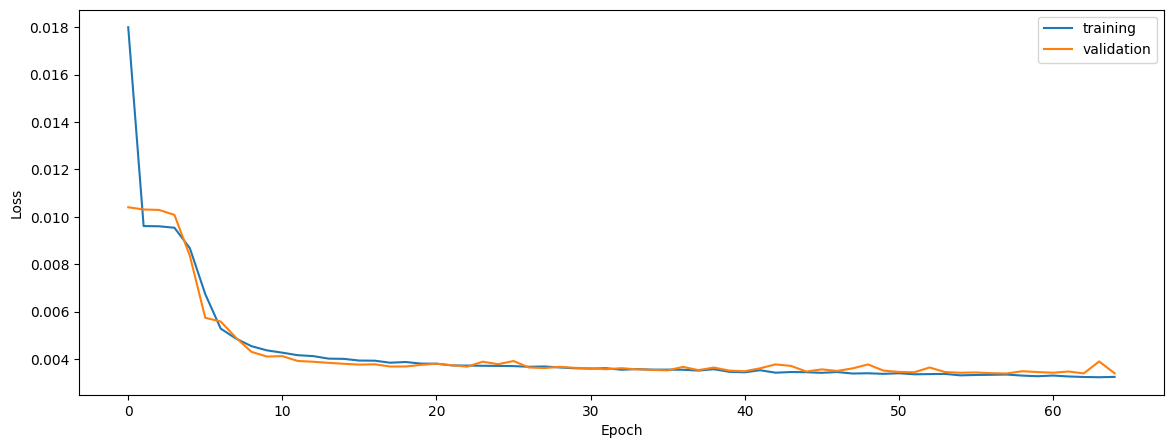

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8151460399931695
0.8196191466070752
0.7753956580137591


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8151460399931695
0.8196191466070752
0.7753956580137591


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.806092061772041
0.8155716058575012
0.7642696870700098


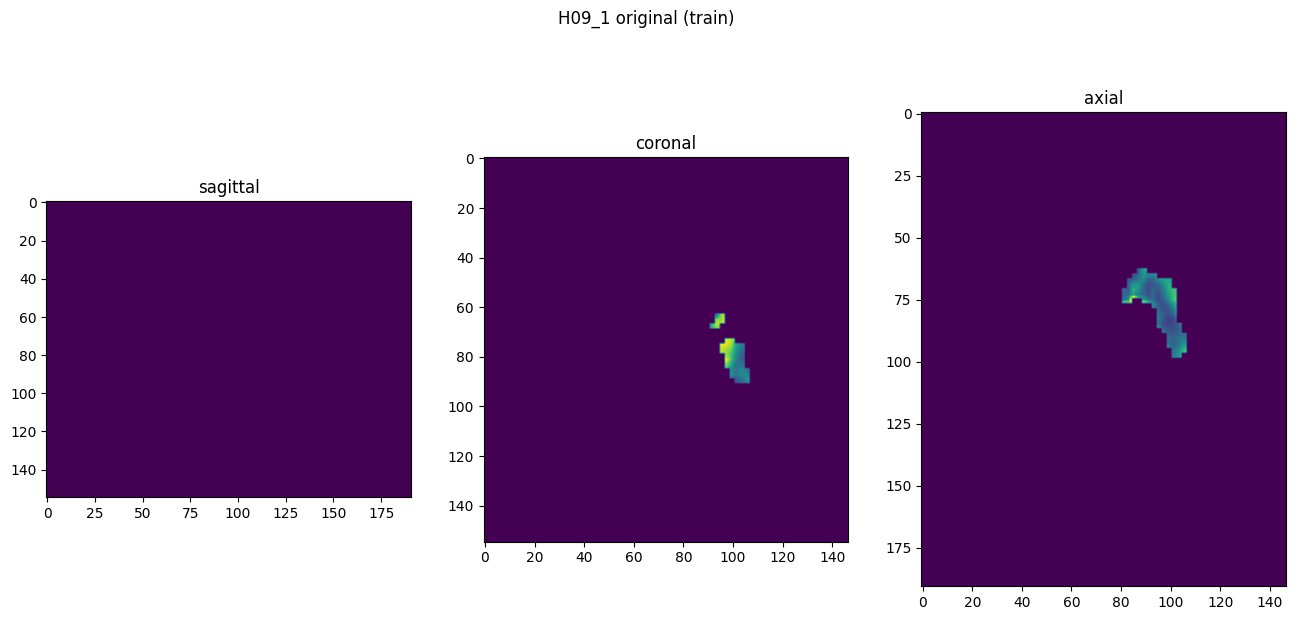

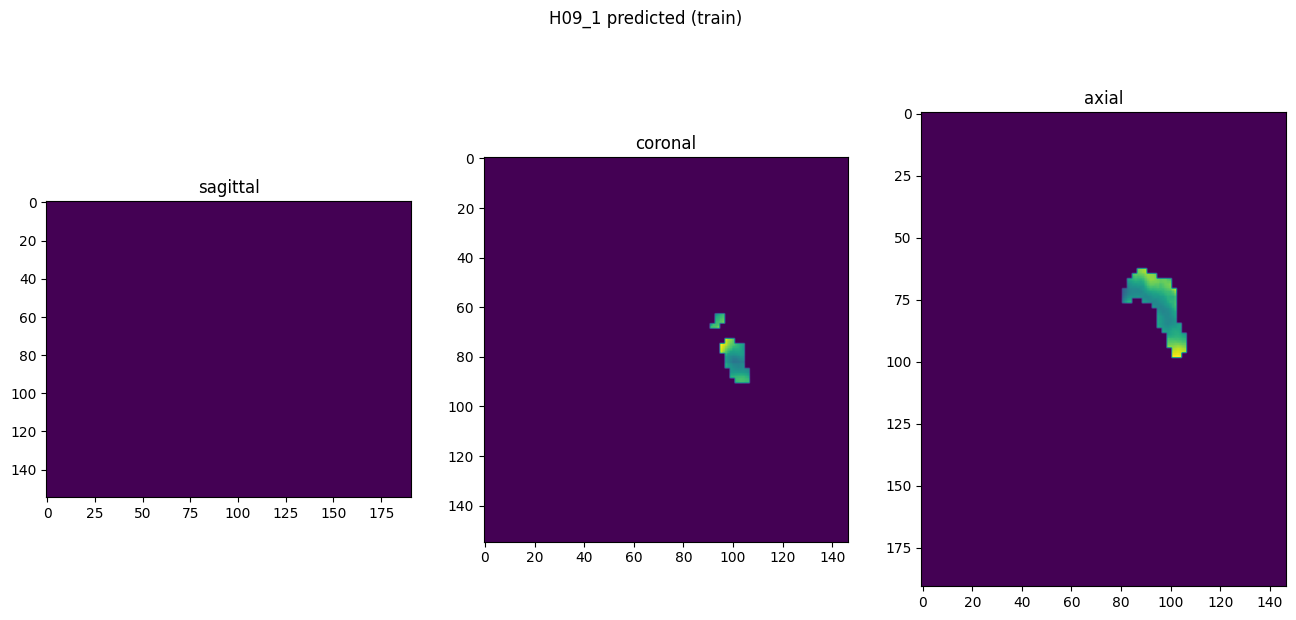

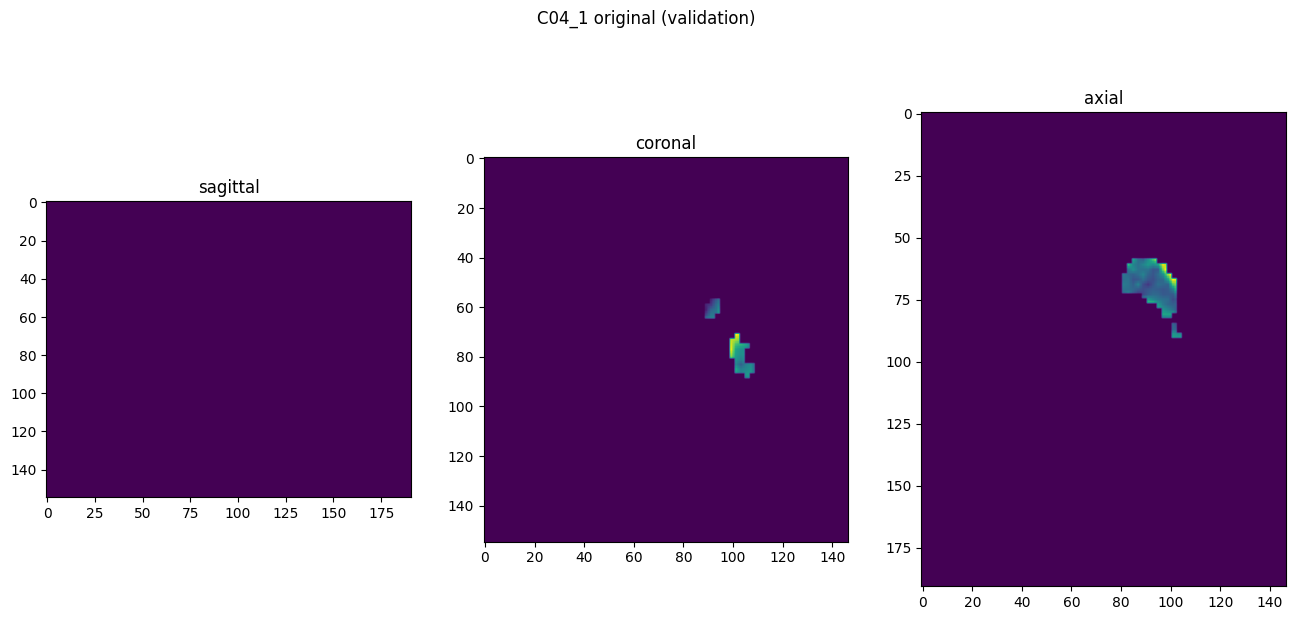

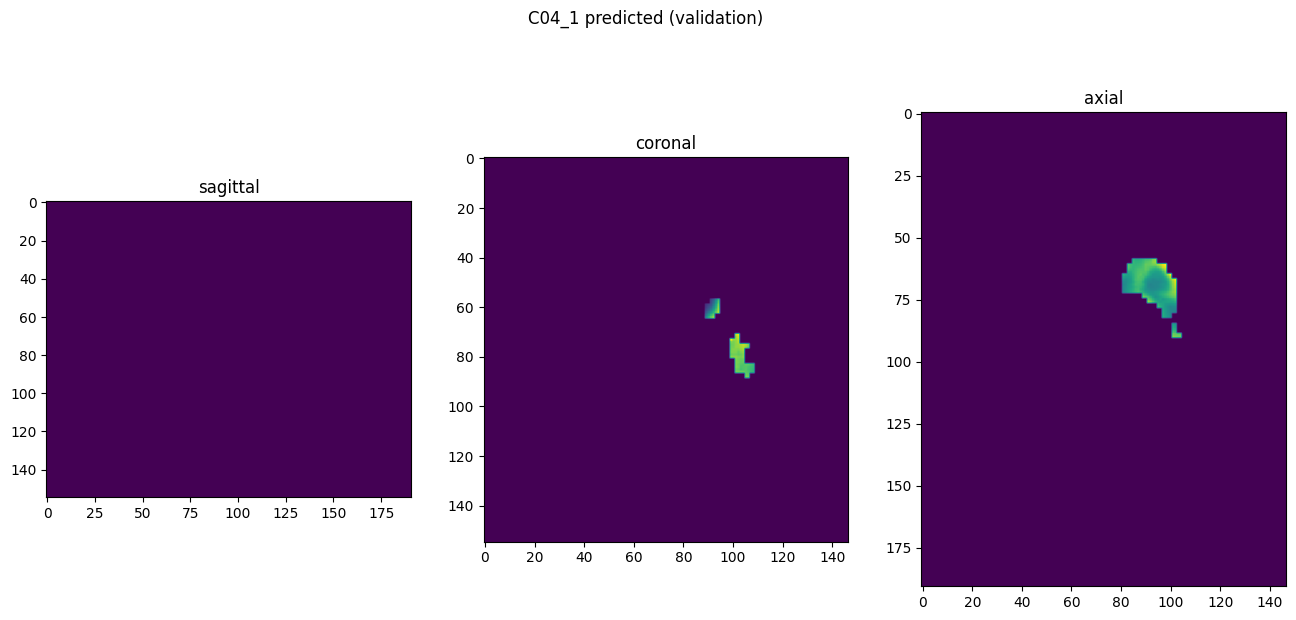

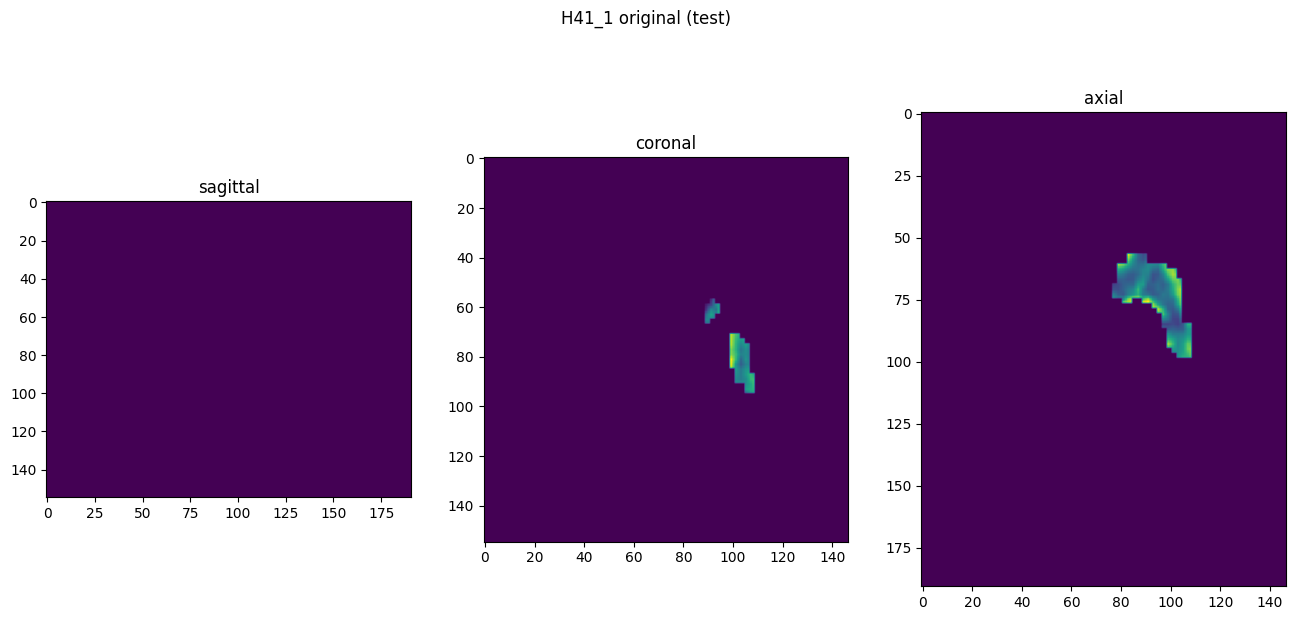

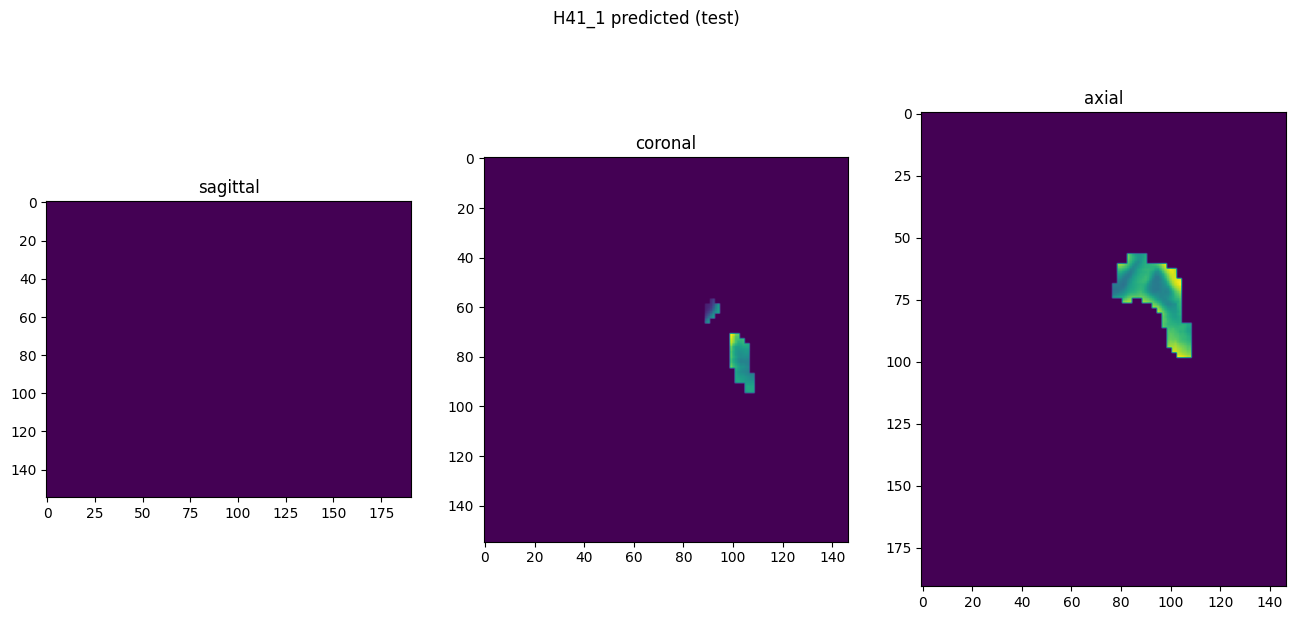

In [10]:
showResults(model, gen, threshold=None, background=False)